<a href="https://colab.research.google.com/github/PrajnyaKulkarni/book_reccommendation_project/blob/main/Project_group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.metrics.pairwise import cosine_similarity
import random

import warnings
warnings.filterwarnings('ignore')

## 1.User dataset

In [ ]:
user = pd.read_excel("D:\\Downloads\\Datasets\\Users.xlsx")
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
user = user.rename({'User-ID':'userId'},axis=1)
user.head()

,userId,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
user.tail()

,userId,Location,Age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


In [ ]:
df1 = user.copy()

In [ ]:
user = user.rename({'User-ID':'userId'},axis=1)
user.head()

,userId,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
user.shape

(278858, 3)

In [ ]:
user.describe()

,userId,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


**Minimum value in the age column is 0 and max value is 244 Which is unusual.So we have to remove outliers**

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId    278858 non-null  int64  
 1   Location  278857 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


**From the info, we get to know that, there is one null in UserId Column and Many null entries in the age column. So we use isna().sum() function to check how many null values are there.**

In [ ]:
user.isna().sum()

userId           0
Location         1
Age         110762
dtype: int64

In [ ]:
#Mean = Sum/no. of terms
user_mis_value_percentage = round(user.isna().mean().mul(100),3)
user_mis_value_percentage

userId       0.00
Location     0.00
Age         39.72
dtype: float64

**As the 39.72% of the data is missing(Before treating outliers), We have to impute the missing values without dropping them.**

In [ ]:
user.duplicated().sum()

0

Text(0.5, 1.0, 'Outlier in the age column')

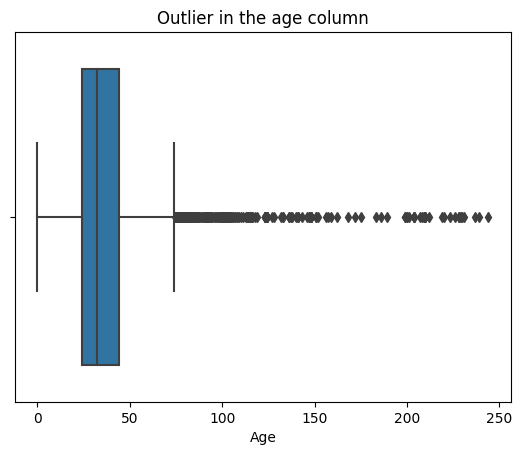

In [ ]:
# Let us visualise the outliers in the data
sns.boxplot(x='Age',data=user)
plt.title('Outlier in the age column')

Text(0.5, 1.0, 'Age Distribution Plot')

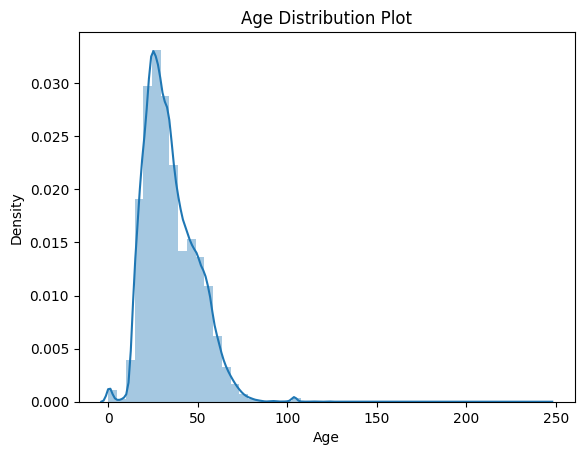

In [ ]:
#Lets check the distribution of the data
sns.distplot(user.Age)
plt.title('Age Distribution Plot')

**As the distribution is right skewed and as we have seen in the box plot, there are more outliers on the right side.**

In [ ]:
#Considering age between 6-100 is valid range of age for readers,all the other ages are converted to null
user.loc[(user['Age']>100) | (user['Age']<6),'Age'] = np.NAN

Text(0.5, 1.0, 'Age Distribution Plot after replacing invalid age')

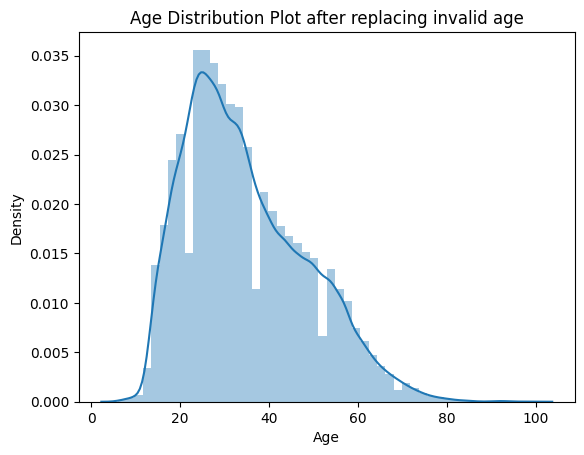

In [ ]:
sns.distplot(user.Age)
plt.title('Age Distribution Plot after replacing invalid age')

**We now check the percentage of null values after replacing outliers to null values.**

In [ ]:
user_mis_value_percent = round(user.isna().mean().mul(100),3)
user_mis_value_percent

userId       0.000
Location     0.000
Age         40.177
dtype: float64

**Let us try imputing the null values using the Location column. Before that, let us treat the Location column first.**

In [ ]:
user.Location.unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

**As it is difficault to group people using location, We split it into 3 columns.**

In [ ]:
user['Country'] = user['Location'].str.rsplit(',').str[-1]
user['State'] = user['Location'].str.rsplit(',').str[1]
user['City'] = user['Location'].str.rsplit(',').str[0]
user.drop('Location',axis=1,inplace=True)
user.head()

,userId,Age,Country,State,City
0,1,NaN,usa,new york,nyc
1,2,18.0,usa,california,stockton
2,3,NaN,russia,yukon territory,moscow
3,4,17.0,portugal,v.n.gaia,porto
4,5,NaN,united kingdom,hants,farnborough


**Here we are grouping the age by Country.**

In [ ]:
user.groupby(by = 'Country')['Age'].mean()

Country
                     34.621335
 &#20013;&#22269;    15.000000
 &#32654;&#22269;    31.000000
 *                         NaN
 -                         NaN
                       ...    
 zimbabwe            28.133333
 Ã¤Â¸Â­Ã¥?Â½         21.000000
 Ã¶Ã°Â¹Ãº            26.800000
"                    32.750000
lawrenceville        30.000000
Name: Age, Length: 709, dtype: float64

**Here we get to know that country column contains numeric and other special characters which should be removed**

In [ ]:
user['Country'] = user['Country'].str.replace("[^a-zA-Z]"," ") #remove all the special characters and the numbers in the Country column
user['Country'] = user['Country'].str.lower()
user['Country'] = user['Country'].str.strip()
user.Country.nunique()

601

**Still 601 unique countries are there. Now let's group the age by Countries**

In [ ]:
user.groupby(by = 'Country')['Age'].mean()

Country
                    34.565763
a                         NaN
aaa                       NaN
adsgfdr                   NaN
afganstand holla          NaN
                      ...    
yunling                   NaN
z                         NaN
zambia              40.333333
zhengjiang                NaN
zimbabwe            28.133333
Name: Age, Length: 601, dtype: float64

**Still some countries are of invalid type. So we have listed all the countries in the dataset.**

In [ ]:
user['Country']=user['Country'].astype('str')
c=list(user.Country.unique())
c=set(c)
c=list(c)
c = [x for x in c if x is not None]
c.sort()
print(c)

['', 'a', 'aaa', 'adsgfdr', 'afganstand holla', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'alg  rie', 'algeria', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'antigua   barbuda', 'antigua and barbuda', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australii', 'austria', 'autralia', 'az', 'azerbaijan', 'bademn w  rtemberg', 'baden w  rttemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belize', 'bell', 'benin', 'bergued', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'bosnia and herzegovina', 'botswana', 'brasil', 'brazil', 'british virgin islands', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burkinafasu', 'burlington', 'burma', 'butler', 'c', 'c  te d', 'c 

In [ ]:
#remove errors in the country names
x = ['', 'aaa', 'adsgfdr','allen','az','bbbzzzzz','bergued','bfe','bih', 'bkk','c', 'c  te d','c a', 'cadd', 'can', 'cass',
     'chad', 'country','cook','csa','cted', 'de', 'der', 'dfg','kern', 'cape may', 'the gambia','st thomasi',
     'amalurra','diy', 'doodedoo', 'ee uu', 'every where and anywhere', 'evil- empire', 'exactly where i am',
     'fairyland', 'far away', 'fred','faroe islands','east africa','tdzimi','fredonia   land of the brave and free',
     'heaven', 'h u g','here and there', 'holy see', 'home of the van', 'id','in your heart', 'input error','k c b',
     'ksa', 'kz', 'l','l alg  rie','lake', 'lane', 'lecce', 'lee', 'lj', 'lkjlj','my', 'n a','n a   on the road', 'nan',
     'neverland','nh','nl', 'no more', 'none', 'nowhere', 'nrw','pa', 'per', 'petrolwarnation','pr','st thomasi'
     'princewilliam', 'rice', 'rmi', 'r o c','serbia montenegro''space','strongbadia', 'the', 'the great white north',
     'the world tomorrow', 'thing','travelling','tyrtyrt', 'u', 'unit','fernando de la mora', 'minnehaha', 'afganstand holla',
     'kosovo','serbia   montenegro', 'somalia', 'trinidad   tobago','valtesse','san mateo', 'davidson', 'saint luica',
     'vatican city','nz','east africa','rutherford','somewherein space', 'universe', 'ussurfing','unknown',
     'uyo','we re global','whatcom','wood', 'x', 'xxxxxx', 'z','dauphin','polska','effingham', 'windham','kosovo',
     'cn', 'jackson','ua','nyhamnsl  ge','saint loius', 'hornyonic', 'nyc', 'washtenaw',
    'la chine   ternelle','brunei darussalam', 'cape town','st  helena', 'sultanate of oman', 'aroostook', 'prince william',
    'bademn w  rtemberg', 'gb', 'worcester','van wert','saudia arabia','maricopa','dublin','carter','osceola','myanmar',
    'rapides', 'essex', 'm  rida', 'antigua   barbuda','belgi', 'pinallas', 'bell','serbia and montenegro','liaoning',
    'clinton', 'basilicata', 'bladen', 'sardegna',  'rosario','burkinafasu', 'henry', 'rosello', 'granville',
     'petrolwar nation','harvatija','prc','sardinia',  'mo  ambique','europa', 'shelby',  'malaysian', 'indiai', 'mordor',
    'fontana', 'kiribati',  'ukrain', 'onondaga nation','queensland', 'solano', 'vorce','la chine eternelle','espanha   galiza',
     'maracopa', 'palestine', 'republic of panama','rsa', 'west yorkshire', 'smith', 'pueblo','pippo','t  rkiye',
    'spotsylvania', 'livingston', 's corea', 'bosnia', 'euskadi','uae', 'yanhill', 'rep san marino', 'johnson', 'maine',
     'buncombe','bucks', 'trinidad tobago', 'houston', 'slovak republik','fortaleza', 'in', 'pistlavakia', 'bavaria',
     's africa','palm beach', 'north carolina', 'russian federation', 'courtenay', 'mauritania', 'hidalgo',
    'xinyu', 'orange co', 'texas', 'baden w  rttemberg', 'a', 'san mateo', 'davidson', 'saint luica','distrito federal',
     'space','evil empire', 'marrion','st  clair', 'rep  san marino', 'victoria','turkei']


#replacing spelling similar to usa, canada, uk with their correct spellings, as they are the top 3 occuring countries in users.
for char in x:
    user['Country'] = user['Country'].replace(char, "other")                          #replace errors with other

y = ['clackamas','ysa','wonderful usa', 'ust', 'uusa', 'us', 'usa', 'usa   canada', 'usa  currently living in england',
     'united sates', 'united staes', 'united state', 'united statea', 'united stated', 'united stated of america',
     'united states', 'united states of america','unite states','u s', 'u s  of a', 'u s  virgin islands', 'u s a',
     'los estados unidos de norte america','hungary and usa','good old u s a', 'good old usa', 'disgruntled states of america',
     'america', 'american samoa','ohio','butler','fort bend','fulton', 'yakima','collin','baxter','hennipen',
    'baltimore', 'hampden','bernalillo','auckland','pasco',  'morgan', 'slo','dekalb', 'maricopa', 'richmond country',
    'framingham', 'monroe','san franicsco','camden','copenhagen','oakland','ventura','ventura county','california']

for char in y:
    user['Country'] = user['Country'].replace(char, "usa")                                #replcae spelling similar to usa with 'usa'


c = ['canada eh', 'cananda', 'canda','il canada','le canada','st clair',]
u = ['england uk','singapore united kingdom', 'united kindgdom', 'united kindgonm','england','u k','united kingdom','uk',
     'st  vincent and the grenadines','austbritania', 'british virgin islands','london','nederlands','frome','english',
    'thailoand','new london','newzealand','northern ireland']

for char in c:
    user['Country'] = user['Country'].replace(char, "canada")                             #replcae spelling similar to canada with 'canada'

for char in u:
    user['Country'] = user['Country'].replace(char, "united kingdom")                                   #replcae spelling similar to uk with 'uk'

m = ['mexico','m       xico','m  xico']

for char in m:
    user['Country'] = user['Country'].replace(char, "mexico")

i = ['calabria','italia','italien', 'italy', 'itlay','rep san marino','toscana','ferrara','milano', 'europe','lazio','italien']

for char in i:
    user['Country'] = user['Country'].replace(char, "italy")


p = ['phils','phila','philippines', 'philippinies', 'phillipines', 'phils', 'phippines','the philippines','philippine',
     'phippines']

for char in p:
    user['Country'] = user['Country'].replace(char, "philippines")

g = ['geermany','germay','ahrensburg']

for char in g:
    user['Country'] = user['Country'].replace(char, "germany")

ch = ['yunling','liushi','people s republic of china','zhengjiang','cnina','hongkong','chian','china people s republic',
      'p r  china']

for char in ch:
    user['Country'] = user['Country'].replace(char, "china")

au = ['rep san marino','autralia','australii']

for char in au:
    user['Country'] = user['Country'].replace(char, "australia")

sw = ['la svizzera','swazilandia','switzerland']

for char in sw:
    user['Country'] = user['Country'].replace(char, "switzerland")

i1 = ['israel', 'isreal']

for char in i1:
    user['Country'] = user['Country'].replace(char, "israel")

sr = ['sri lanka  n a','srilanka','sri lanka']

for char in sr:
    user['Country'] = user['Country'].replace(char, "srilanka")

**Here we have checked which are countries are having most value counts(Frequency of the country)**

In [ ]:
user.Country.value_counts().reset_index()

,index,Country
0,usa,139787
1,canada,21664
2,united kingdom,18612
3,germany,17076
4,spain,13257
...,...,...
262,sicilia,1
263,alachua,1
264,hillsborough,1
265,greece hellas,1


In [ ]:
#Lets us check the age for diff countries
user_age_country = user.groupby(['Country', 'Age']).size().reset_index().rename(columns={0:'Num of users'}).sort_values(by = 'Num of users', ascending = False)

In [ ]:
user_age_country

,Country,Age,Num of users
4030,usa,34.0,2189
4029,usa,33.0,1982
4031,usa,35.0,1980
4028,usa,32.0,1930
4025,usa,29.0,1930
...,...,...,...
2055,jamaica,56.0,1
2056,jamaica,70.0,1
2057,japan,14.0,1
2061,japan,19.0,1


**Here we are checking the age distribution of top three frequent countries**

Text(0.5, 1.0, 'Age Distribution of USA users')

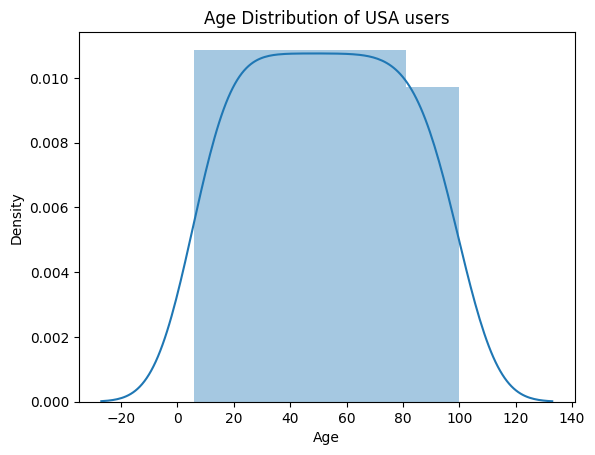

In [ ]:
sns.distplot(user_age_country[user_age_country['Country'] == "usa"].Age)
plt.title("Age Distribution of USA users")

**For USA, the age distribution is same for all the ages.That means, the readers of USA are of all the ages between 6 - 100**

Text(0.5, 1.0, 'Age Distribution of UK users')

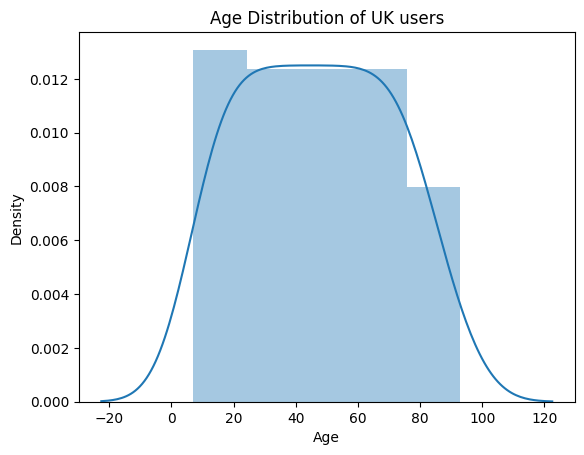

In [ ]:
sns.distplot(user_age_country[user_age_country['Country'] == "united kingdom"].Age)
plt.title("Age Distribution of UK users")

**In UK, the readers of age 15 - 25 are more. And the age range is between 15-70**

Text(0.5, 1.0, 'Age Distribution of canada users')

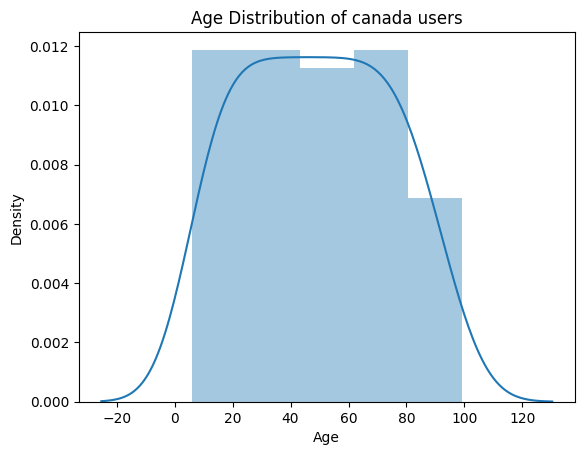

In [ ]:
sns.distplot(user_age_country[user_age_country['Country'] == "canada"].Age)
plt.title("Age Distribution of canada users")

**In canada, there are readers from 6 - 100 age group.And the readers of age group 6-80 are more.**

In [ ]:
user['Age'] = user['Age'].fillna(round(user.groupby('Country')['Age'].transform('median'), 0))

**Here, we take mean of the age of each country's users to replace the NA in age columns for corresponding country's users**

In [ ]:
user_null_new =  user[user.Age.isna()]
user_null_new

,userId,Age,Country,State,City


In [ ]:
user.isnull().sum()

userId     0
Age        0
Country    0
State      2
City       1
dtype: int64

**As all the null values in the age are treated and the state and city column is not needed, state and city are dropped**

In [ ]:
user = user.drop(['State','City'],axis =1)
user.head()

,userId,Age,Country
0,1,36.0,usa
1,2,18.0,usa
2,3,23.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom


##### Top 10 Count of users Country wise

Text(0.5, 1.0, 'Count of users Country wise')

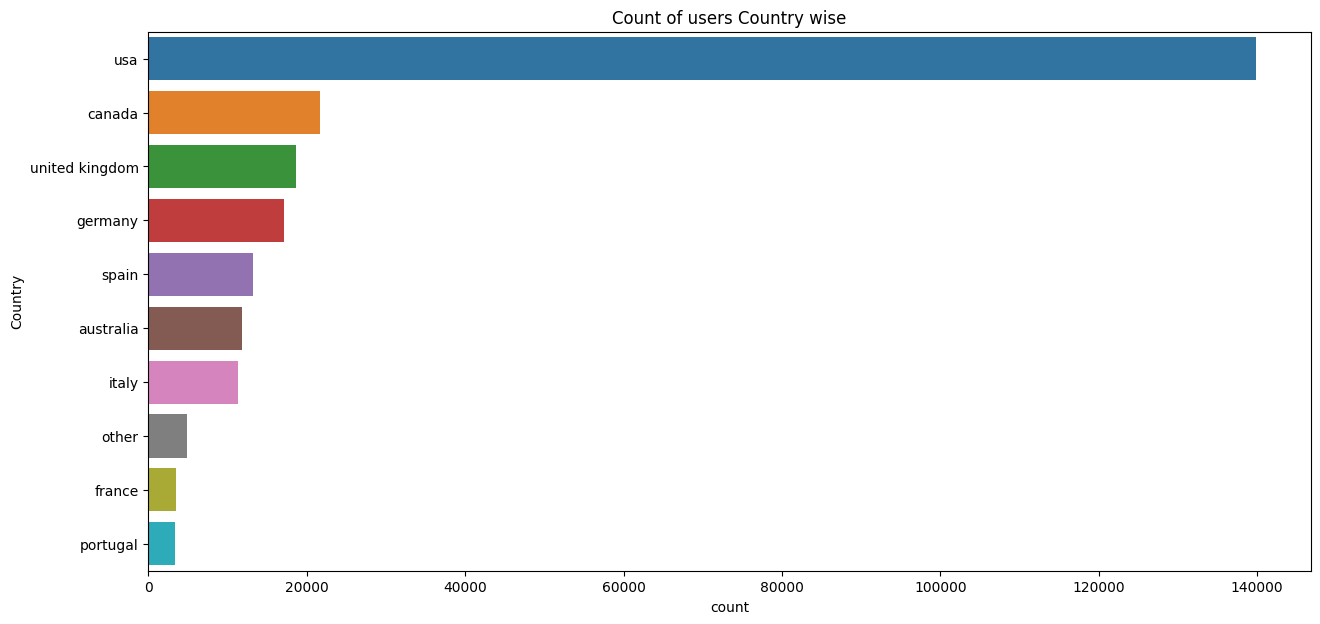

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'Country',data = user,order=pd.value_counts(user['Country']).iloc[:10].index)
plt.title('Count of users Country wise')

## 2.Book dataset

In [ ]:
book = pd.read_excel("D:\\Downloads\\Datasets\\Books.xlsx")
pd.set_option('display.max_colwidth', None)
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
book.tail()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
271355,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.LZZZZZZZ.jpg
271356,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.LZZZZZZZ.jpg
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.LZZZZZZZ.jpg
271358,192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.LZZZZZZZ.jpg
271359,767409752,A Guided Tour of Rene Descartes' Meditations on First Philosophy with Complete Translations of the Meditations by Ronald Rubin,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0767409752.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767409752.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767409752.01.LZZZZZZZ.jpg


In [ ]:
df2 = book.copy()

In [ ]:
book = book.rename({'Book-Rating':'rating','Book-Title':'bookTitle',
                    'Book-Author':'bookAuthor','Year-Of-Publication':'publicationYear'},axis=1)
book.head()

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
book["bookTitle"] = book["bookTitle"].astype('str')

In [ ]:
book["bookTitle"]=book["bookTitle"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())

In [ ]:
book.shape

(271360, 8)

In [ ]:
book.describe(include='all')

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,240112,102023,118,16806,271044,271044,271041
top,195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/185326119X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/225307649X.01.LZZZZZZZ.jpg
freq,1,27,632,17627,7535,2,2,2


* **Here there are 271360 unique ISBN numbers.**
* **4 book titles are missing. Means, 271356 books are there in which 241360 book titles are unique.We have to check if the books are having different series or it is set of duplicated values.Selected poems is appeared 27 times. We have to find out the reason.**
* **Here they are showing Agatha christie is a top author.It means her books are more.Here 632 books are written by agatha Christie.One book author name is missing. Out of 271359 books, 102023 authors are unique.**
* **There is no null values in year of publication.books published in 2002 are more.**
* **There are 2 null values in Publisher's name. 16806 unique publishers are there.Herlequin published the maximum number of (7535) books.**
* **No null values in image URL S and M columns. There are 3 null values in image URL L column.And image URL also seems to have duplicates. We have to work on that.**

In [ ]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ISBN             271360 non-null  object
 1   bookTitle        271360 non-null  object
 2   bookAuthor       271359 non-null  object
 3   publicationYear  271360 non-null  object
 4   Publisher        271358 non-null  object
 5   Image-URL-S      271360 non-null  object
 6   Image-URL-M      271360 non-null  object
 7   Image-URL-L      271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


**The Year of publication column should be integer type. It is showing as object. We have to check that.**

In [ ]:
book.isna().sum()

ISBN               0
bookTitle          0
bookAuthor         1
publicationYear    0
Publisher          2
Image-URL-S        0
Image-URL-M        0
Image-URL-L        3
dtype: int64

In [ ]:
book.duplicated().sum()

0

In [ ]:
#Let us check the missing Image-URL-L
book.loc[book['Image-URL-L'].isna()]

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,DK Readers Creating the X Men How It All Began Level 4 Proficient Readers Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN
220731,2070426769,Peuple du ciel suivi de Les Bergers Jean Marie Gustave Le ClÃƒ Ã Â zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN
221678,789466953,DK Readers Creating the X Men How Comic Books Come to Life Level 4 Proficient Readers James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN


* **We can clearly see here that this is a data entry mistake, columns from book-author have been shifted left, (title and author are clubbed in one row seperated by (\ " ;)**
* **We have to treat these columns**

In [ ]:
#Create a seperate df for these 3 rows
edit_df = book.loc[book['Image-URL-L'].isna()]

In [ ]:
edit_df['Image-URL-L'] = edit_df['Image-URL-M']
edit_df['Image-URL-M'] = edit_df['Image-URL-S']
edit_df['Image-URL-S'] = edit_df['Publisher']
edit_df['Publisher'] = edit_df['publicationYear']
edit_df['publicationYear'] = edit_df['bookAuthor']

In [ ]:
edit_df

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,DK Readers Creating the X Men How It All Began Level 4 Proficient Readers Michael Teitelbaum,2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg
220731,2070426769,Peuple du ciel suivi de Les Bergers Jean Marie Gustave Le ClÃƒ Ã Â zio,2003,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg
221678,789466953,DK Readers Creating the X Men How Comic Books Come to Life Level 4 Proficient Readers James Buckley,2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg


In [ ]:
edit_df.loc[edit_df.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
edit_df.loc[edit_df.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [ ]:
edit_df.loc[edit_df.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio"
edit_df.loc[edit_df.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [ ]:
edit_df.loc[edit_df.ISBN == 789466953,'bookAuthor'] = "James Buckley"
edit_df.loc[edit_df.ISBN == 789466953,'bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [ ]:
edit_df

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg
220731,2070426769,Peuple du ciel suivi de Les Bergers Jean Marie Gustave Le ClÃƒ Ã Â zio,2003,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg
221678,789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg


In [ ]:
#replace book_df rows with edit_df rows
book[book.index == 221678] = edit_df[edit_df.index == 221678]
book[book.index == 220731] = edit_df[edit_df.index == 220731]
book[book.index == 209538] = edit_df[edit_df.index == 209538]

In [ ]:
book.dtypes

ISBN               object
bookTitle          object
bookAuthor         object
publicationYear    object
Publisher          object
Image-URL-S        object
Image-URL-M        object
Image-URL-L        object
dtype: object

* **There seems to be an error in Year-of-Publication as it is still showing as object dtype and with no missing values.**

In [ ]:
sorted(book['publicationYear'].unique())

[0,
 1376,
 1378,
 1806,
 1897,
 1900,
 1901,
 1902,
 1904,
 1906,
 1908,
 1909,
 1910,
 1911,
 1914,
 1917,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2008,
 2010,
 2011,
 2012,
 2020,
 2021,
 2024,
 2026,
 2030,
 2037,
 2038,
 2050]

In [ ]:
book[book['publicationYear']>2022].shape

(13, 8)

In [ ]:
book[book['publicationYear']==0].shape

(4618, 8)

* **We have to treat Year-of-Publication = 0 and >2022**

In [ ]:
#We'll set the year=0 and > 2022 as null values and try to treat them
book.loc[(book['publicationYear'] > 2022) | (book['publicationYear'] == 0),'publicationYear'] = np.NAN

In [ ]:
book.isna().sum()

ISBN                  0
bookTitle             0
bookAuthor            1
publicationYear    4631
Publisher             2
Image-URL-S           0
Image-URL-M           0
Image-URL-L           0
dtype: int64

<AxesSubplot: xlabel='publicationYear', ylabel='Density'>

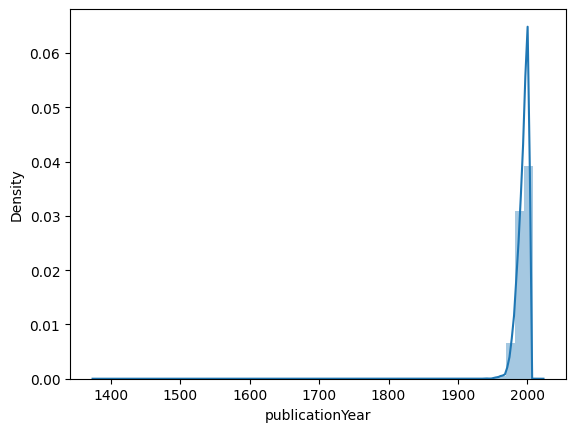

In [ ]:
sns.distplot(book['publicationYear'])

In [ ]:
print("Mean=", round(book['publicationYear'].mean()))
print("Median=", round(book['publicationYear'].median()))
print("Mode=", book['publicationYear'].mode())

Mean= 1994
Median= 1996
Mode= 0    2002
Name: publicationYear, dtype: object


In [ ]:
#we will fill the null values with median of the valid years
book['publicationYear'].fillna(round(book['publicationYear'].median()), inplace=True)

In [ ]:
book.isnull().sum()

ISBN               0
bookTitle          0
bookAuthor         1
publicationYear    0
Publisher          2
Image-URL-S        0
Image-URL-M        0
Image-URL-L        0
dtype: int64

In [ ]:
book_mis_value_percentage = round(book.isna().mean().mul(100),3)
book_mis_value_percentage

ISBN               0.000
bookTitle          0.000
bookAuthor         0.000
publicationYear    0.000
Publisher          0.001
Image-URL-S        0.000
Image-URL-M        0.000
Image-URL-L        0.000
dtype: float64

* **As the missing value is 0.02% we can drop the rows.**

In [ ]:
book = book.dropna()
book.isna().sum()

ISBN               0
bookTitle          0
bookAuthor         0
publicationYear    0
Publisher          0
Image-URL-S        0
Image-URL-M        0
Image-URL-L        0
dtype: int64

In [ ]:
book.dtypes

ISBN               object
bookTitle          object
bookAuthor         object
publicationYear     int64
Publisher          object
Image-URL-S        object
Image-URL-M        object
Image-URL-L        object
dtype: object

* **Now all the data types are correct and null datas are imputed**

Text(0.5, 1.0, 'Authors who have written most number of books')

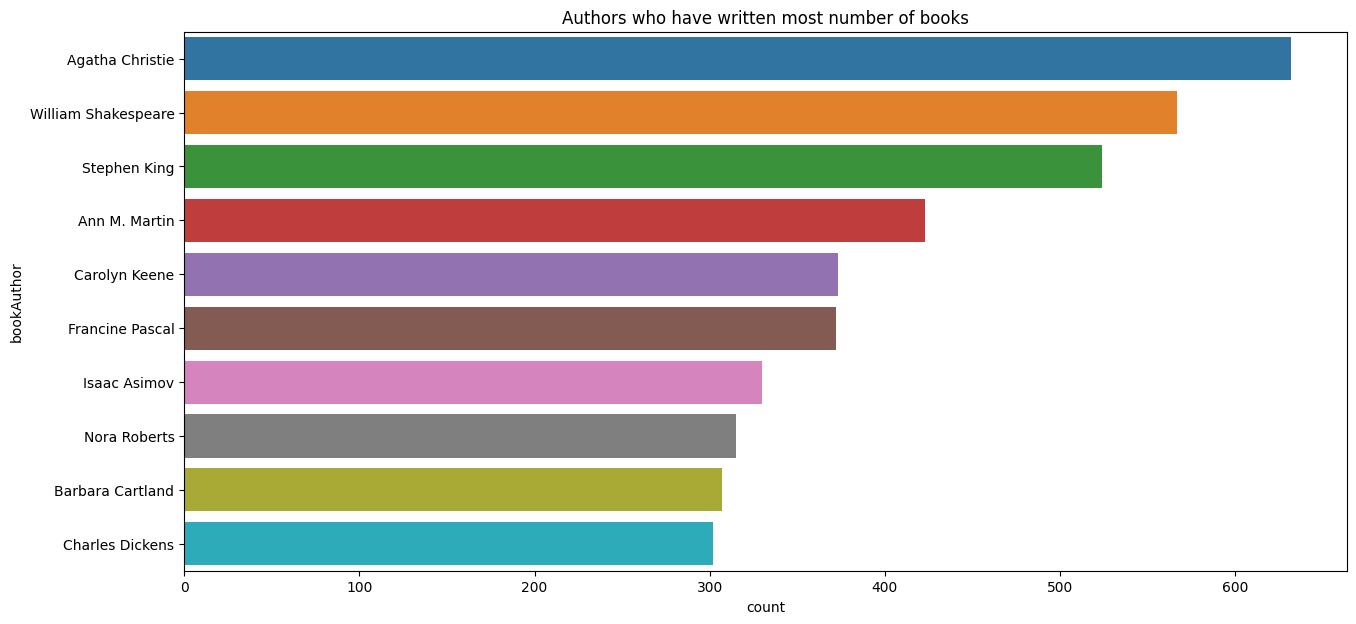

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'bookAuthor',data = book,order=pd.value_counts(book['bookAuthor']).iloc[:10].index)
plt.title('Authors who have written most number of books')

* **Agatha Christie is the author who has written maximum number of books.**

Text(0.5, 1.0, 'Top years in which most number of books are published')

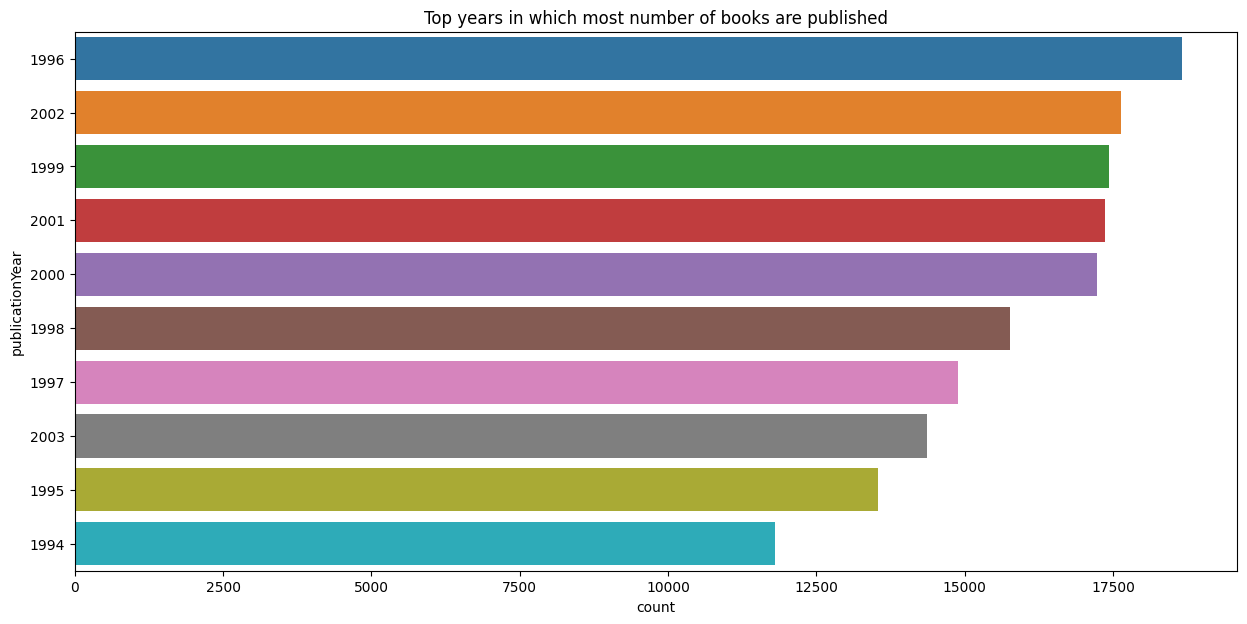

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'publicationYear',data = book,order=pd.value_counts(book['publicationYear']).iloc[:10].index)
plt.title('Top years in which most number of books are published')

* **1996 is the year when the most number of books were published**

## Rating dataset

In [ ]:
rating = pd.read_excel("D:\\Downloads\\Datasets\\Ratings.xlsx")
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [ ]:
rating = rating.rename({'User-ID':'userId','Book-Rating':'rating'},axis=1)
rating.head()

,userId,ISBN,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [ ]:
rating.shape

(1048575, 3)

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   userId  1048575 non-null  int64 
 1   ISBN    1048575 non-null  object
 2   rating  1048575 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


* **From the info, we can clearly say that all the data types are correct and there is no null value**

In [ ]:
rating.isna().sum()

userId    0
ISBN      0
rating    0
dtype: int64

In [ ]:
rating.duplicated().sum()

24

In [ ]:
rating[rating.duplicated()]

,userId,ISBN,rating
59326,11795,0,7
59327,11795,0,0
114974,26535,843947624,0
191582,42400,552079545,0
215369,50321,0,0
215370,50321,0,0
227041,52584,399501487,0
299926,71285,0,0
299928,71285,0,0
303089,72352,6537300425,7


In [ ]:
round(rating.describe(), 2)

,userId,rating
count,1048575.00,1048575.00
mean,128508.90,2.88
std,74218.76,3.86
min,2.00,0.00
25%,63394.00,0.00
50%,128835.00,0.00
75%,192779.00,7.00
max,278854.00,10.00


* **Here we can see ratings start from 0. But 0 rating means the user didn't read the book or read the book but didn't rate the book**
* **So we calculate the percentage of ratings which are 0.**

In [ ]:
rating_duplicated_percentage = (24/1048575)*100
rating_duplicated_percentage

0.002288820542164366

* **So We remove all the duplicate values**
* **Also We see ISBN 0 in the rating dataset which is not in book dataset. We have to drop that too**

In [ ]:
rating.drop_duplicates(inplace = True)

In [ ]:
rating.shape

(1048551, 3)

In [ ]:
rating

,userId,ISBN,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6
...,...,...,...
1048570,250764,451410777,0
1048571,250764,452264464,8
1048572,250764,048623715X,0
1048573,250764,486256588,0


In [ ]:
rating_new = rating[rating.ISBN.isin(book.ISBN)]
rating.shape,rating_new.shape

((1048551, 3), (941103, 3))

* **ISBN which are not in book dataset but in rating dataset are removed. And they are 107454 rows. (They are about 10% of the dataset).**
* **We will not be considering user that are not in the user_df but are in the rating_df dataset as they will not help us to provide complete analysis.**

In [ ]:
print("Shape of dataset before dropping",rating_new.shape)
rating_new = rating_new[rating_new['userId'].isin(user['userId'])]
print("shape of dataset after dropping",rating_new.shape)

Shape of dataset before dropping (941103, 3)
shape of dataset after dropping (941103, 3)


* **There are no new user in rating df other than user df**

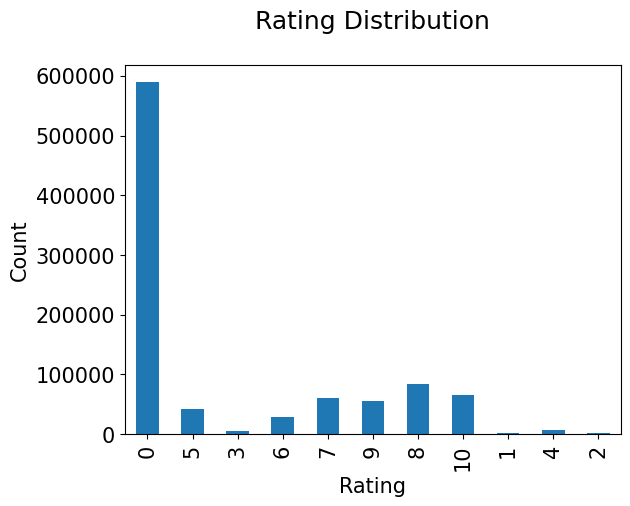

In [ ]:
plt.rc("font", size=15)
rating_new['rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

* **From the graph, We got to know that, the books that are having 0 rating are more than others. So We check the percentage of 0 rating books and the books which are rated 1-10**

In [ ]:
print("% of books that have been rated between 1-10:" , round(((rating_new[rating_new['rating'] != 0].shape[0]/rating_new.shape[0])*100), 2), "%")
print("% of books that have been purchased/read/viewed by user but not rated:" , round(((rating_new[rating_new['rating'] == 0].shape[0]/rating_new.shape[0])*100), 2), "%")

% of books that have been rated between 1-10: 37.39 %
% of books that have been purchased/read/viewed by user but not rated: 62.61 %


**Now we check how is the distribution between 1-10 rated books**

<AxesSubplot: title={'center': 'Rating Distribution between 1-10\n'}, xlabel='rating', ylabel='count'>

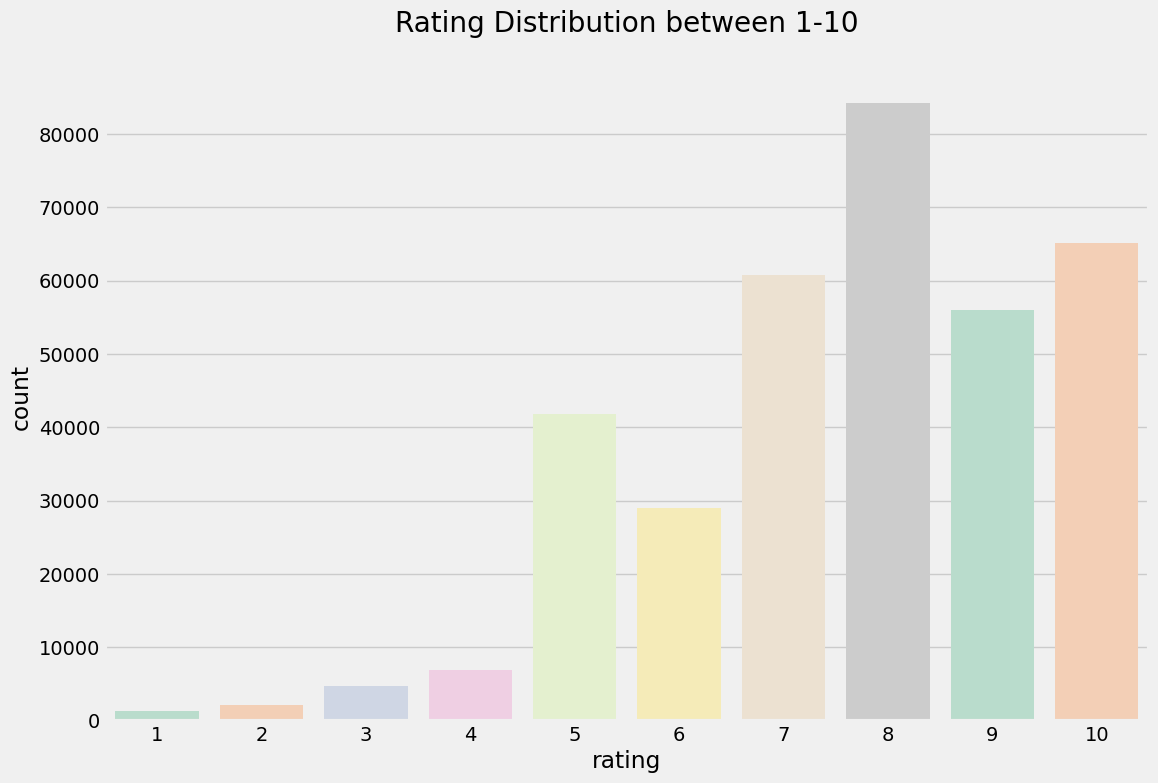

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.title('Rating Distribution between 1-10\n')
sns.countplot(data = rating_new[rating_new['rating'] != 0] , x='rating', palette='Pastel2')

**Here we can see that 8 is the frequently rated number and 1 is the rarely rated number**

In [ ]:
#top 10 books which have been rated by the user max number of times
rating_count = pd.DataFrame(rating_new[rating_new['rating'] != 0].groupby('ISBN')['rating'].count())
rating_count.sort_values('rating', ascending=False).head(10)

,rating
ISBN,
316666343,635
971880107,526
385504209,452
312195516,354
60928336,292
059035342X,285
142001740,283
446672211,265
044023722X,259


In [ ]:
most_rated_books = pd.DataFrame([[316666343, 635], [971880107, 526], [385504209,452], [312195516, 354], [60928336, 292], ['059035342X', 285], [142001740,283], [446672211,265], ['044023722X', 259], [452282152,257]], index=np.arange(10), columns = ['ISBN', 'Number of ratings'])
most_rated_books_summary = pd.merge(most_rated_books, book, on='ISBN')
most_rated_books_summary

,ISBN,Number of ratings,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,316666343,635,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
1,971880107,526,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
2,385504209,452,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
3,312195516,354,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
4,60928336,292,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
5,059035342X,285,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
6,142001740,283,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
7,446672211,265,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
8,044023722X,259,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
9,452282152,257,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books')

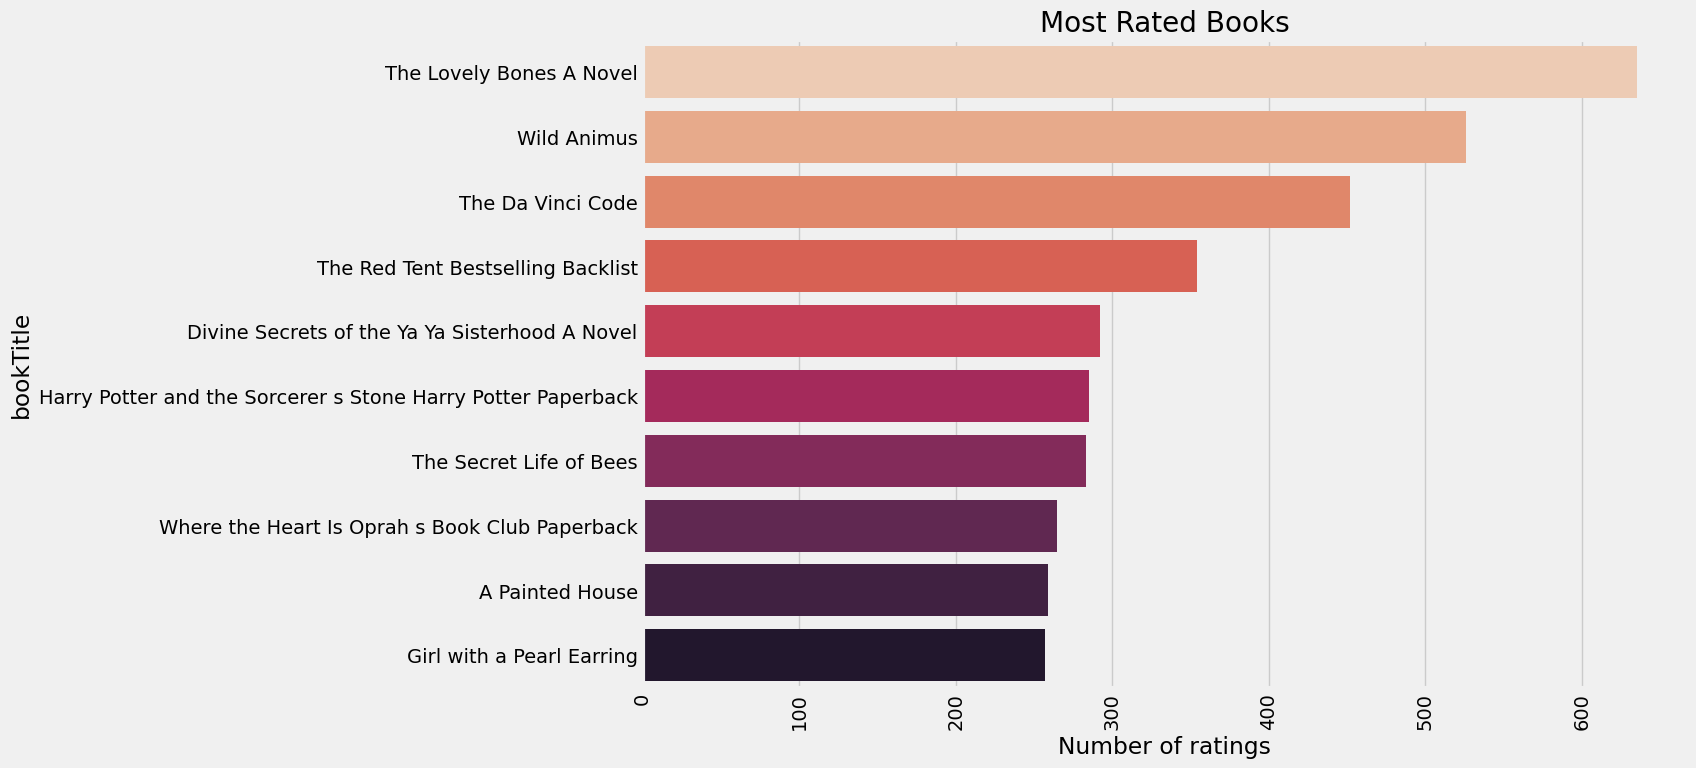

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_rated_books_summary , y='bookTitle', x = 'Number of ratings' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books")

* **The Lovely Bones: A Novel is the book that is rated by most number of users.**

In [ ]:
#top 10 books which have been viewed/read/purchased by the user max number of times
viewed_count = pd.DataFrame(rating_new[rating_new['rating'] == 0].groupby('ISBN')['rating'].count())
viewed_count.sort_values('rating', ascending=False).head(10)

,rating
ISBN,
971880107,1737
316666343,529
60928336,370
385504209,361
044023722X,336
067976402X,320
440214041,314
312195516,314
804106304,298


In [ ]:
most_viewed_books = pd.DataFrame([[971880107, 1738], [316666343,529], [60928336,370], [385504209,361], ['044023722X',336],
                                  ['067976402X',320], [440214041,314], [312195516,314], [804106304,298], [440211727,293]], index=np.arange(10), columns = ['ISBN', 'Number of views without ratings'])
most_viewed_books_summary = pd.merge(most_viewed_books, book, on='ISBN')
most_viewed_books_summary

,ISBN,Number of views without ratings,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,971880107,1738,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1,316666343,529,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
2,60928336,370,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
3,385504209,361,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
4,044023722X,336,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
5,067976402X,320,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.LZZZZZZZ.jpg
6,440214041,314,The Pelican Brief,John Grisham,1993,Dell,http://images.amazon.com/images/P/0440214041.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440214041.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440214041.01.LZZZZZZZ.jpg
7,312195516,314,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
8,804106304,298,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),http://images.amazon.com/images/P/0804106304.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.LZZZZZZZ.jpg
9,440211727,293,A Time to Kill,JOHN GRISHAM,1992,Dell,http://images.amazon.com/images/P/0440211727.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440211727.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440211727.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'The books which are most read/viewed but not rated')

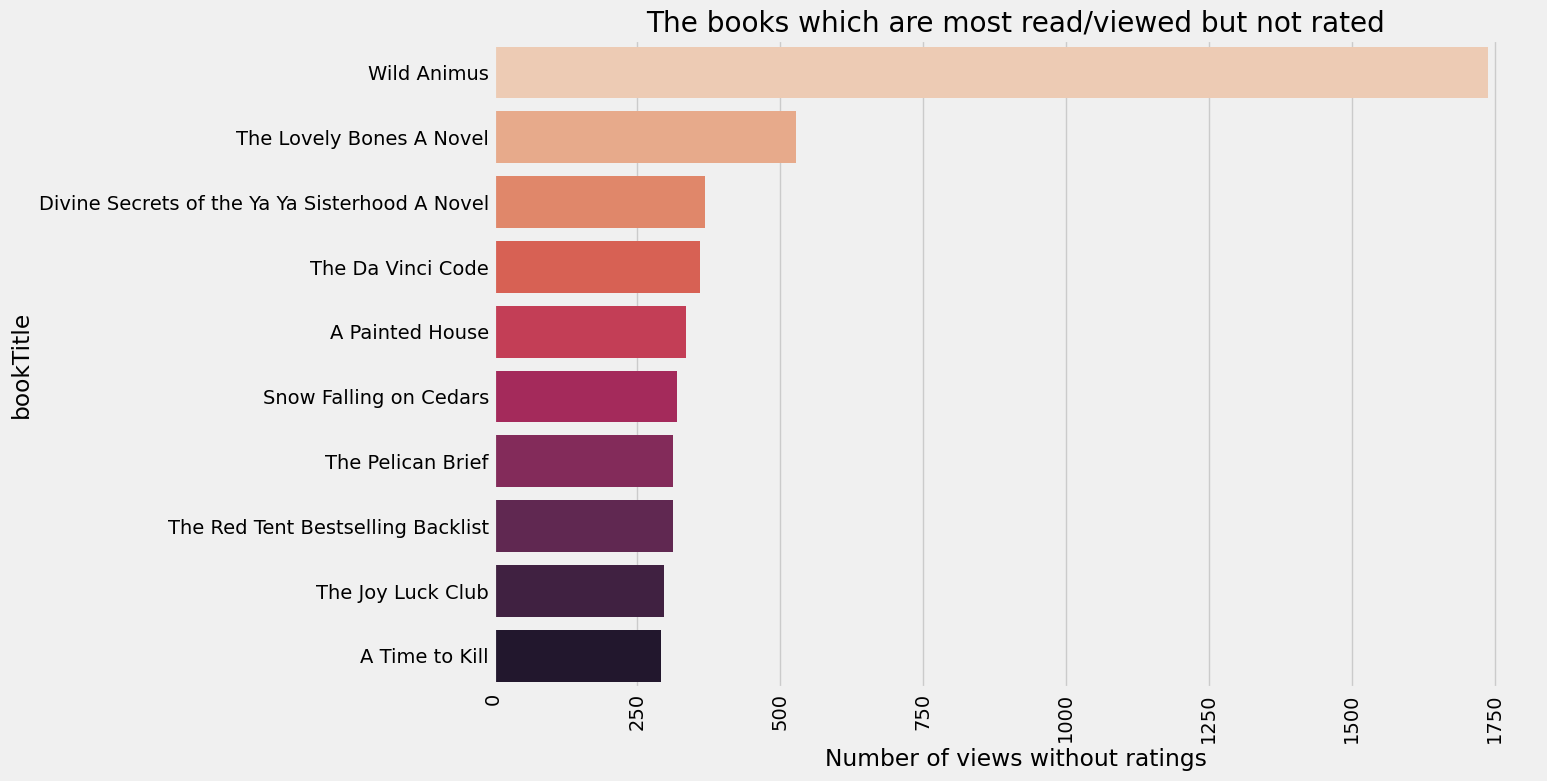

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_viewed_books_summary , y='bookTitle', x = 'Number of views without ratings' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("The books which are most read/viewed but not rated")

* **Wild animus novels is read/viewed/purchased many times. But not rated**

In [ ]:
#User-ID who has purchased/read/viewed most books but not rated
user_count_read = pd.DataFrame(rating_new[rating_new['rating'] == 0].groupby('userId')['rating'].count())
user_count_read.sort_values('rating', ascending=False).head(10)

,rating
userId,
198711,6439
35859,4869
212898,4286
11676,4202
153662,3970
278418,3891
76352,3266
110973,2684
234623,2553


In [ ]:
most_user_read = pd.DataFrame([[198711, 6439], [35859,4869], [212898,4286], [11676,4202], [153662,3970], [278418,3891], [76352,3266], [110973,2684], [234623,2553], [230522,2542]], index=np.arange(10), columns = ['userId', 'Number of ratings'])
most_user_read_summary = pd.merge(most_user_read, user, on='userId')
most_user_read_summary

,userId,Number of ratings,Age,Country
0,198711,6439,62.0,usa
1,35859,4869,36.0,usa
2,212898,4286,33.0,canada
3,11676,4202,32.0,other
4,153662,3970,44.0,usa
5,278418,3891,36.0,usa
6,76352,3266,58.0,usa
7,110973,2684,43.0,usa
8,234623,2553,36.0,usa
9,230522,2542,52.0,usa


* **Most people who viewed/Purchased/read the book but not rated are from USA and are of the age range 36-62**
* **User ID 198711 read 6439 number of books but not rated them.(?)**


Text(0.5, 1.0, 'Most Users who have read and/or purchased')

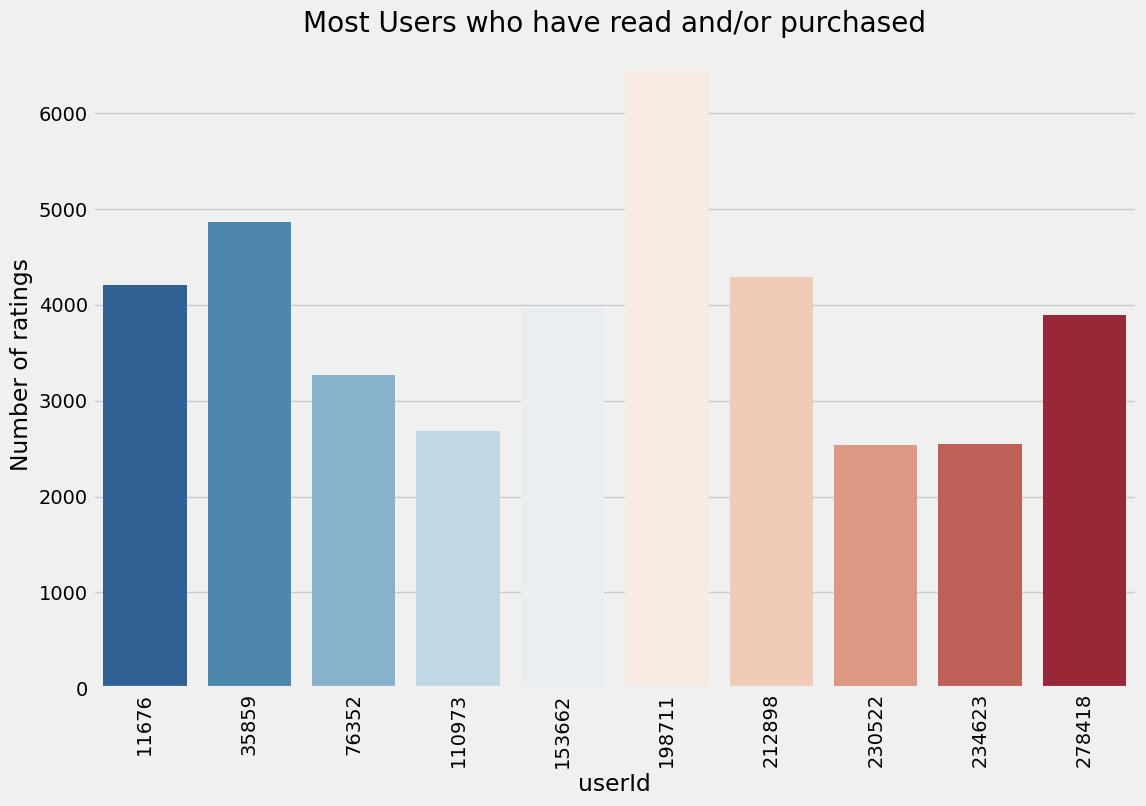

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_user_read_summary , x='userId', y = 'Number of ratings' ,palette='RdBu_r')
plt.xticks(rotation=90)
plt.title("Most Users who have read and/or purchased")

In [ ]:
#User-ID who has rated most books
user_count_rated = pd.DataFrame(rating_new[rating_new['rating'] != 0].groupby('userId')['rating'].count())
user_count_rated.sort_values('rating', ascending=False).head(10)

,rating
userId,
11676,6945
98391,5689
189835,1899
153662,1847
23902,1181
235105,1020
76499,1012
171118,962
16795,960


In [ ]:
most_user_rated = pd.DataFrame([[11676,6945], [98391,5691], [189835,1899], [153662,1847], [23902,1181], [235105,1020], [76499,1012], [171118,962], [16795,960], [248718,941]], index=np.arange(10), columns = ['userId', 'Number of ratings'])
most_user_rated_summary = pd.merge(most_user_rated, user, on='userId')
most_user_rated_summary

,userId,Number of ratings,Age,Country
0,11676,6945,32.0,other
1,98391,5691,52.0,usa
2,189835,1899,36.0,usa
3,153662,1847,44.0,usa
4,23902,1181,32.0,united kingdom
5,235105,1020,46.0,usa
6,76499,1012,36.0,usa
7,171118,962,47.0,canada
8,16795,960,47.0,usa
9,248718,941,43.0,usa


* **User ID 11676 which has read most number of books and also rated is from some unknown country.Other UserIDs are From USA, canada and Uk.**
* **In USA, The age range of people who have rated along with reading the book are from the age range 36-52.**


Text(0.5, 1.0, 'Most Users who have rated')

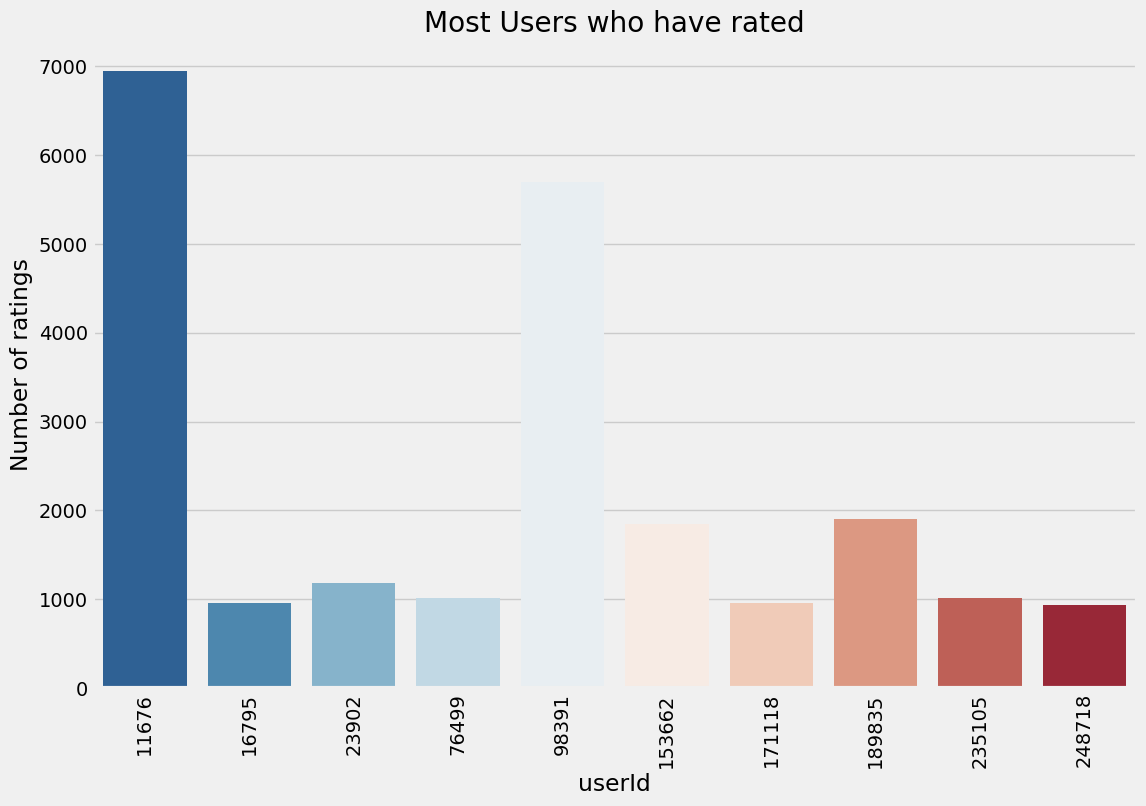

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_user_rated_summary , x='userId', y = 'Number of ratings' ,palette='RdBu_r')
plt.xticks(rotation=90)
plt.title("Most Users who have rated")

### Merging All Dataset

In [ ]:
Final_dataset = user.copy()
Final_dataset = pd.merge(Final_dataset, rating_new, on='userId')
Final_dataset = pd.merge(Final_dataset,book,on='ISBN')

In [ ]:
Final_dataset.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,18.0,usa,195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,8,33.0,canada,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,11400,49.0,canada,2005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
3,11676,32.0,other,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
4,41385,33.0,canada,2005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg


In [ ]:
round(Final_dataset.isna().mean().mul(100),3)

userId             0.0
Age                0.0
Country            0.0
ISBN               0.0
rating             0.0
bookTitle          0.0
bookAuthor         0.0
publicationYear    0.0
Publisher          0.0
Image-URL-S        0.0
Image-URL-M        0.0
Image-URL-L        0.0
dtype: float64

In [ ]:
Final_dataset.shape

(941103, 12)

In [ ]:
Final_dataset['Publication_century']=pd.cut(x=Final_dataset['publicationYear'],bins=[1300,1800,1899,1999,2021], right=True,
                                 labels=[13,18,19,20])

In [ ]:
Final_dataset['Age_group']=pd.cut(x=Final_dataset['Age'],bins=[0,12,19,49,100], right=True,
                                 labels=['kid','Teenager','Adult','old'])

In [ ]:
Final_dataset.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,2,18.0,usa,195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,20,Teenager
1,8,33.0,canada,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,11400,49.0,canada,2005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
3,11676,32.0,other,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,41385,33.0,canada,2005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


### Divide complete data on the basis of implicit and Explicit ratings datasets

In [ ]:
## Explicit Ratings Dataset
Final_dataset1 = Final_dataset[Final_dataset['rating'] != 0]
Final_dataset1 = Final_dataset1.reset_index(drop = True)
Final_dataset1.shape

(351854, 14)

In [ ]:
## implicit Ratings Dataset
Final_dataset2 = Final_dataset[Final_dataset['rating'] == 0]
Final_dataset2 = Final_dataset2.reset_index(drop = True)
Final_dataset2.shape

(589249, 14)

## Popularity based recommendation

### Country-wise Filter

In [ ]:
Final_dataset1_usa =  Final_dataset1[(Final_dataset1['Country'] == 'usa')]
Final_dataset1_usa.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
8,2954,71.0,usa,60973129,8,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,old
10,35704,53.0,usa,374157065,6,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,old
11,110912,36.0,usa,374157065,10,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult
12,157969,30.0,usa,374157065,8,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult
13,192665,47.0,usa,374157065,8,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult


In [ ]:
Final_dataset1_uk =  Final_dataset1[(Final_dataset1['Country'] == 'united kingdom')]
Final_dataset1_uk.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
203,12863,29.0,united kingdom,452264464,9,Beloved Plume Contemporary Fiction,Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.LZZZZZZZ.jpg,19,Adult
208,27624,54.0,united kingdom,452264464,8,Beloved Plume Contemporary Fiction,Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.LZZZZZZZ.jpg,19,old
243,132930,29.0,united kingdom,452264464,9,Beloved Plume Contemporary Fiction,Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.LZZZZZZZ.jpg,19,Adult
297,4131,51.0,united kingdom,971880107,1,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg,20,old
302,7105,32.0,united kingdom,971880107,6,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg,20,Adult


In [ ]:
Final_dataset1_canada =  Final_dataset1[(Final_dataset1['Country'] == 'canada')]
Final_dataset1_canada.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,8,33.0,canada,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,67544,30.0,canada,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,123629,33.0,canada,2005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
5,200273,33.0,canada,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
6,210926,33.0,canada,2005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


### Age-wise filter

In [ ]:
Final_dataset1_kid =  Final_dataset1[(Final_dataset1['Age_group'] == 'kid')]
Final_dataset1_kid.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
684,197792,7.0,australia,971880107,3,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg,20,kid
1470,208510,12.0,usa,449005615,10,Seabiscuit An American Legend,LAURA HILLENBRAND,2002,Ballantine Books,http://images.amazon.com/images/P/0449005615.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0449005615.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0449005615.01.LZZZZZZZ.jpg,20,kid
8827,277203,8.0,usa,590629719,10,Clifford s Sports Day,Norman Bridwell,1996,Scholastic,http://images.amazon.com/images/P/0590629719.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590629719.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590629719.01.LZZZZZZZ.jpg,19,kid
10083,168464,11.0,usa,64401774,3,More Scary Stories To Tell In The Dark,Alvin Schwartz,1986,HarperTrophy,http://images.amazon.com/images/P/0064401774.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0064401774.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0064401774.01.LZZZZZZZ.jpg,19,kid
10120,208555,12.0,usa,64471047,8,The Lion the Witch and the Wardrobe The Chronicles of Narnia Book 2,C. S. Lewis,1994,HarperCollins,http://images.amazon.com/images/P/0064471047.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0064471047.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0064471047.01.LZZZZZZZ.jpg,19,kid


In [ ]:
Final_dataset1_adult =  Final_dataset1[(Final_dataset1['Age_group'] == 'Adult')]
Final_dataset1_adult.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,8,33.0,canada,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
1,11676,32.0,other,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,67544,30.0,canada,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
3,116866,32.0,other,2005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,123629,33.0,canada,2005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


In [ ]:
Final_dataset1_old =  Final_dataset1[(Final_dataset1['Age_group'] == 'old')]
Final_dataset1_old.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
7,219008,60.0,canada,2005018,7,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,old
8,2954,71.0,usa,60973129,8,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,old
10,35704,53.0,usa,374157065,6,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,old
28,230522,52.0,usa,399135782,7,The Kitchen God s Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,19,old
45,7352,53.0,usa,440234743,8,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440234743.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440234743.01.LZZZZZZZ.jpg,19,old


### Century-wise filter

In [ ]:
Final_dataset1_19 =  Final_dataset1[(Final_dataset1['Publication_century'] == 19)]
Final_dataset1_19.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
8,2954,71.0,usa,60973129,8,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,old
9,152827,40.0,canada,60973129,7,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,Adult
10,35704,53.0,usa,374157065,6,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,old
11,110912,36.0,usa,374157065,10,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult
12,157969,30.0,usa,374157065,8,Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult


In [ ]:
Final_dataset1_20 =  Final_dataset1[(Final_dataset1['Publication_century'] == 20)]
Final_dataset1_20.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,8,33.0,canada,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
1,11676,32.0,other,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,67544,30.0,canada,2005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
3,116866,32.0,other,2005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,123629,33.0,canada,2005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


### Popular books for whole collection

In [ ]:
ratings_count = pd.DataFrame(Final_dataset1.groupby(['ISBN'])['rating'].sum())
top_10 = ratings_count.sort_values('rating',ascending=False).head(10)
top_10 = top_10.merge(book,left_index = True,right_on = 'ISBN')
top_10

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5188,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3814,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2890,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2546,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2404,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2337,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1105,2292,60928336,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2145,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
118,2043,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
231,2040,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in whole collection')

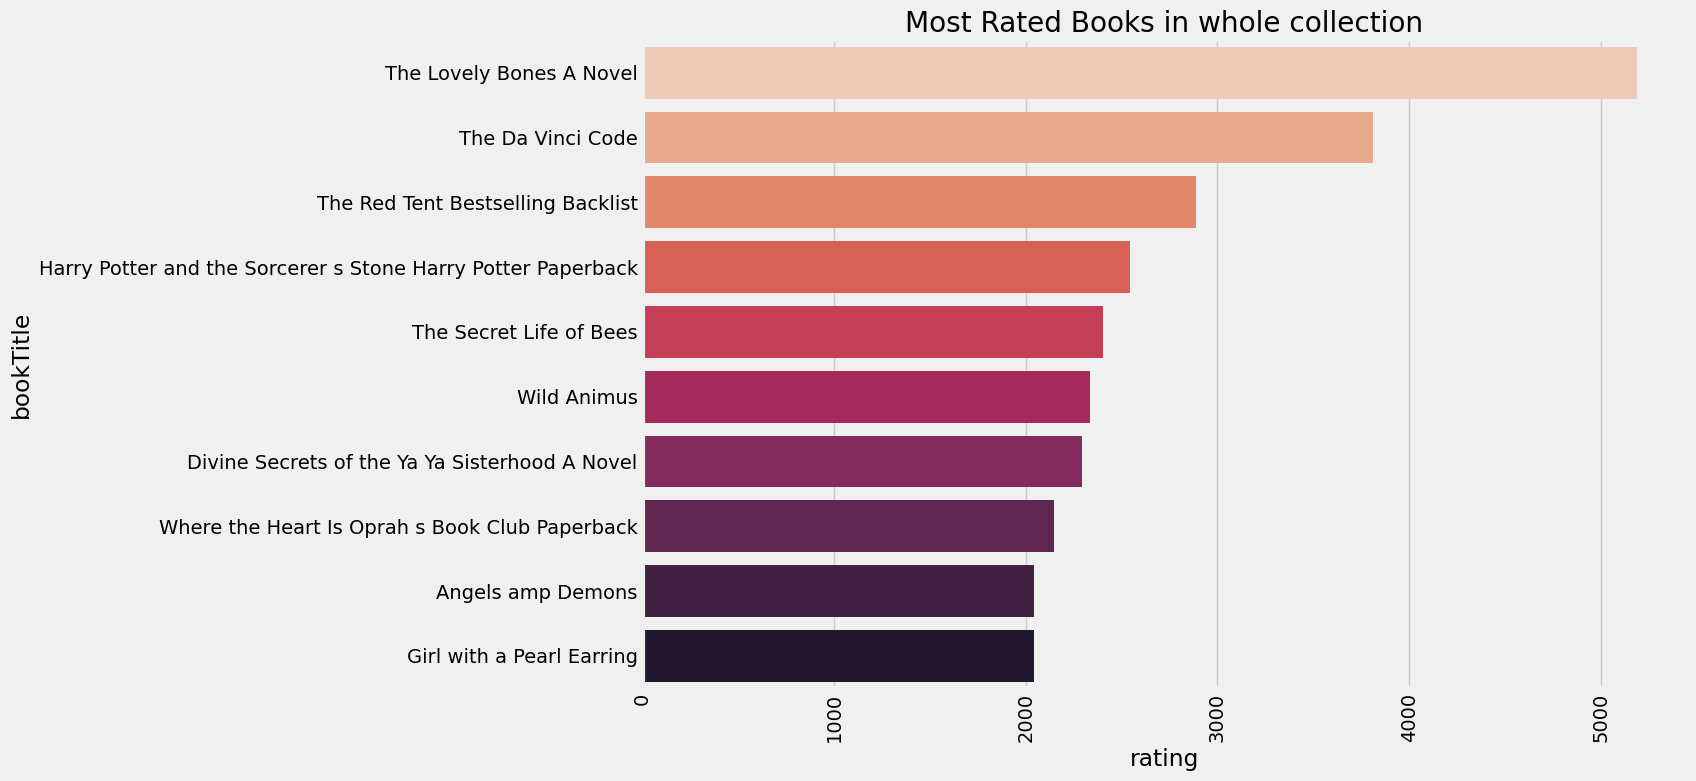

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in whole collection")

1. **The above chart shows the top 10 books in whole collection. We can recommend these books to the people who don't provide information about their age or country**
2. **"The Lovely Bones:A Novel" is the most popular book even though it is read by less number of people(around 500) as compared to "Wild Animus" which is read by around 1750 people. But "Wild Animus" is the 6th Popular book.**

### Q1 : Does popularity of books differ for different countries?

In [ ]:
ratings_count_usa = pd.DataFrame(Final_dataset1_usa.groupby(['ISBN'])['rating'].sum())
top_10_usa = ratings_count_usa.sort_values('rating',ascending=False).head(10)
top_10_usa= top_10_usa.merge(book,left_index = True,right_on = 'ISBN')
top_10_usa

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,3937,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3111,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2276,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2178,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2124,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
1105,1933,60928336,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
118,1709,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
706,1648,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
305,1597,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
231,1591,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in usa')

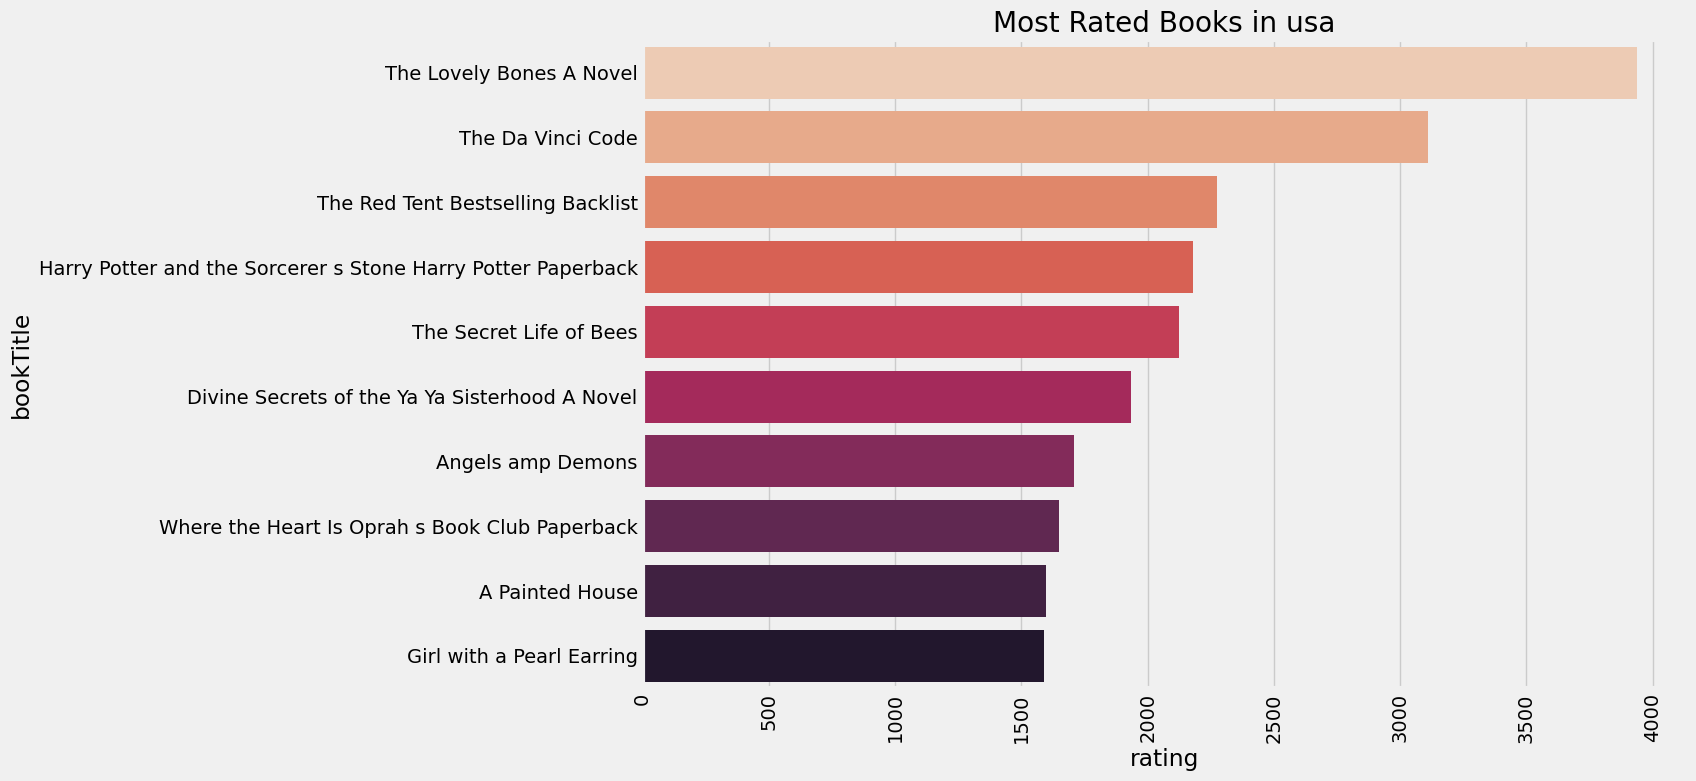

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_usa, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in usa")

1. **The above graph shows top 10 popular books in USA.**
2. **We have to observe one more fact that 9 out of 10 popular books of USA are same as popular books of whole collection.Because, USA contains about 60% of users in the whole dataset.**

In [ ]:
ratings_count_uk = pd.DataFrame(Final_dataset1_uk.groupby(['ISBN'])['rating'].sum())
top_10_uk = ratings_count_uk.sort_values('rating',ascending=False).head(10)
top_10_uk = top_10_uk.merge(book,left_index = True,right_on = 'ISBN')
top_10_uk

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
3028,357,1844262553,Free,Paul Vincent,2003,Upfront Publishing,http://images.amazon.com/images/P/1844262553.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1844262553.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1844262553.01.LZZZZZZZ.jpg
166,305,330332775,Bridget Jones s Diary,Helen Fielding,1997,Picador (UK),http://images.amazon.com/images/P/0330332775.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0330332775.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0330332775.01.LZZZZZZZ.jpg
1263,298,99771519,Memoirs of a Geisha Uk,Arthur Golden,1996,Trafalgar Square,http://images.amazon.com/images/P/0099771519.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.LZZZZZZZ.jpg
5424,228,552998486,Chocolat,Joanne Harris,2000,Black Swan,http://images.amazon.com/images/P/0552998486.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0552998486.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0552998486.01.LZZZZZZZ.jpg
1381,207,552996009,Notes From a Small Planet,Bill Bryson,1996,Bantam Doubleday Dell,http://images.amazon.com/images/P/0552996009.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0552996009.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0552996009.01.LZZZZZZZ.jpg
1386,197,590660543,Northern Lights His Dark Materials S,Philip Pullman,1998,Scholastic Point,http://images.amazon.com/images/P/0590660543.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590660543.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590660543.01.LZZZZZZZ.jpg
1261,186,000649840X,Angelas Ashes,Frank Mccourt,1996,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.LZZZZZZZ.jpg
810,163,349101779,The Wasp Factory,Iain Banks,1996,Abacus,http://images.amazon.com/images/P/0349101779.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0349101779.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0349101779.01.LZZZZZZZ.jpg
35059,159,552999458,Dead Famous,Ben Elton,2002,"Black Swan Books, Limited",http://images.amazon.com/images/P/0552999458.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0552999458.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0552999458.01.LZZZZZZZ.jpg
6698,153,7110928,Billy,Pamela Stephenson,2002,HarperCollins Entertainment,http://images.amazon.com/images/P/0007110928.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0007110928.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0007110928.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in uk')

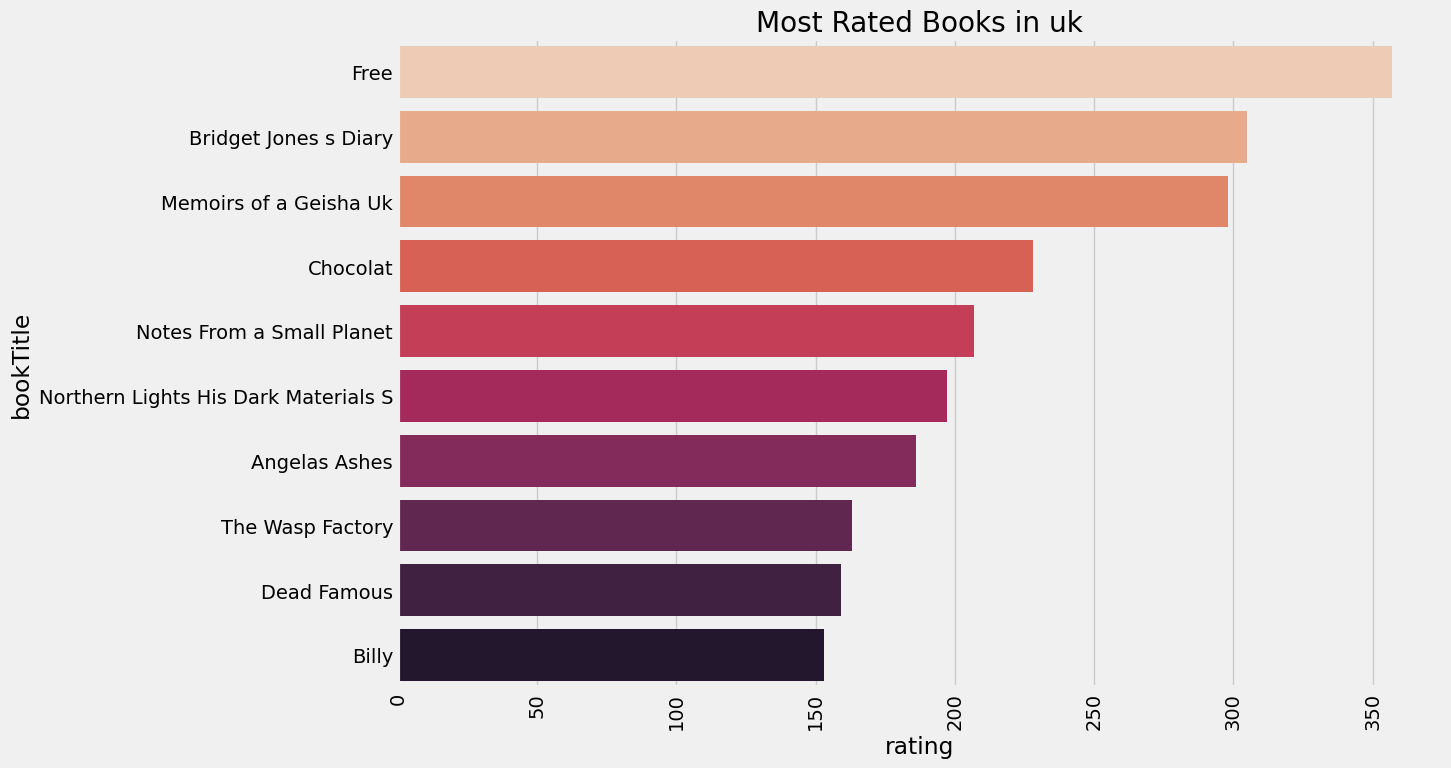

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_uk, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in uk")

1. **In UK, the most popular book is "Free".**
2. **We can see that Popular books of USA and UK differ from each other**

In [ ]:
ratings_count_canada = pd.DataFrame(Final_dataset1_canada.groupby(['ISBN'])['rating'].sum())
top_10_canada = ratings_count_canada.sort_values('rating',ascending=False).head(10)
top_10_canada = top_10_canada.merge(book,left_index = True,right_on = 'ISBN')
top_10_canada

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,448,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
522,312,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
485,308,671021001,She s Come Undone Oprah s Book Club,Wally Lamb,1998,Pocket,http://images.amazon.com/images/P/0671021001.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671021001.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671021001.01.LZZZZZZZ.jpg
67,303,804106304,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),http://images.amazon.com/images/P/0804106304.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.LZZZZZZZ.jpg
5662,272,440241073,The Summons,John Grisham,2002,Dell Publishing Company,http://images.amazon.com/images/P/0440241073.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.LZZZZZZZ.jpg
2445,252,440214041,The Pelican Brief,John Grisham,1993,Dell,http://images.amazon.com/images/P/0440214041.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440214041.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440214041.01.LZZZZZZZ.jpg
4578,248,684872153,Angela s Ashes MMP A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0684872153.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0684872153.01.LZZZZZZZ.jpg
1922,244,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.LZZZZZZZ.jpg
706,239,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
2526,233,345337662,Interview with the Vampire,Anne Rice,1993,Ballantine Books,http://images.amazon.com/images/P/0345337662.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in canada')

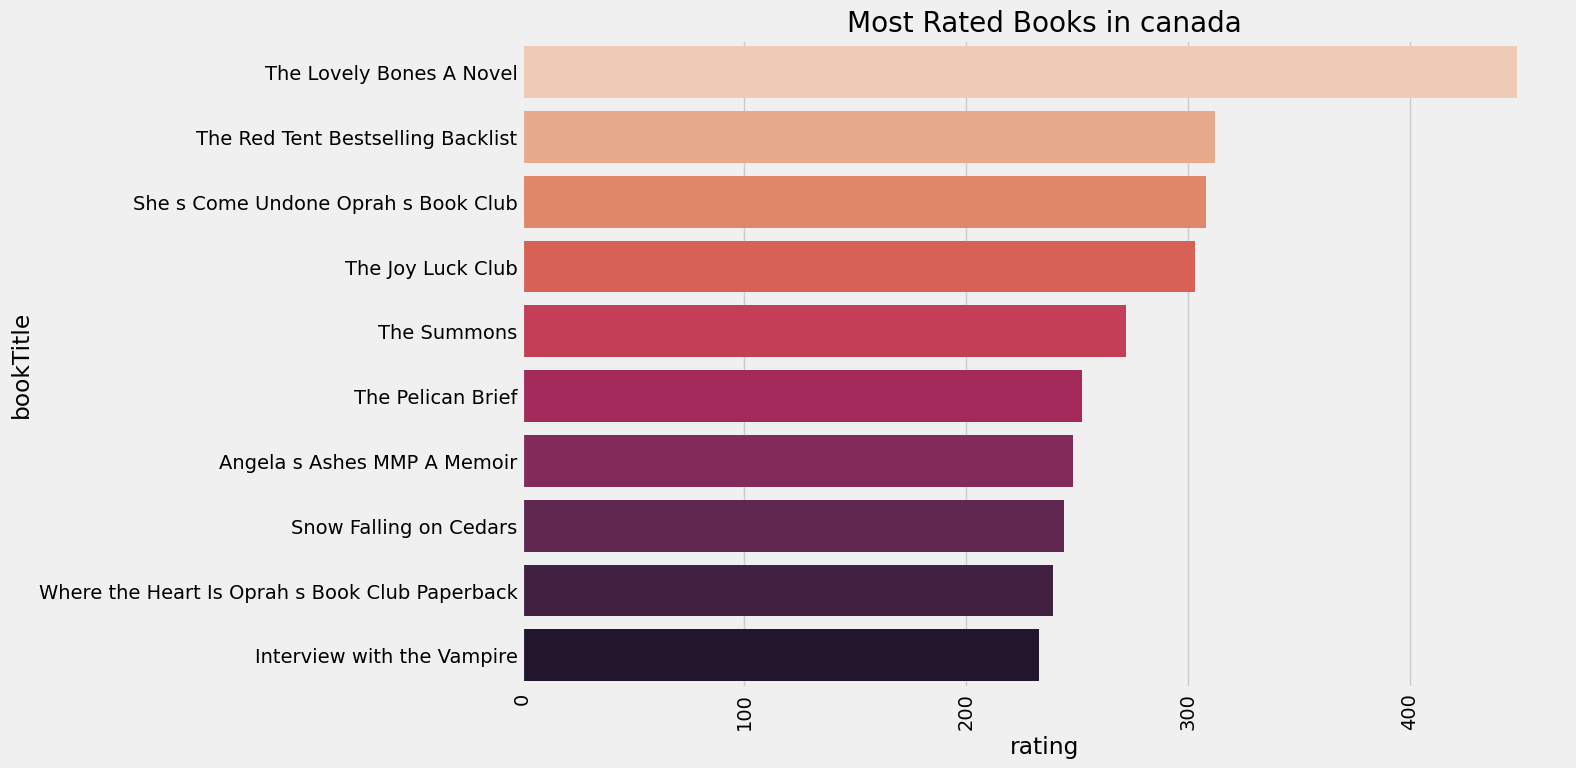

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_canada, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in canada")

1. **Even in canada, Most popular book is The "The Lovely Bones : A Novel" is the most popular book.**
2. **The popular books of Canada, USA and UK are completely different even though USA and canada belong to the same continent**

#### So, Popularity differ from country to country. So we have to build different recommendation engine to different countries

### Q2. Does popularity differ for different age-groups?

In [ ]:
ratings_count_kid = pd.DataFrame(Final_dataset1_kid.groupby(['ISBN'])['rating'].sum())
top_10_kid = ratings_count_kid.sort_values('rating',ascending=False).head(10)
top_10_kid = top_10_kid.merge(book,left_index = True,right_on = 'ISBN')
top_10_kid

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
800,38,64407667,The Bad Beginning A Series of Unfortunate Events Book 1,Lemony Snicket,1999,HarperCollins,http://images.amazon.com/images/P/0064407667.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0064407667.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0064407667.01.LZZZZZZZ.jpg
2143,37,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
36293,35,440407524,Shiloh Yearling Newbery,Phyllis Reynolds Naylor,1992,Yearling Books,http://images.amazon.com/images/P/0440407524.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440407524.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440407524.01.LZZZZZZZ.jpg
10306,30,439049962,Captain Underpants and the Invasion of the Incredibly Naughty Cafeteria Ladies from Outer Space,Dav Pilkey,1999,Scholastic,http://images.amazon.com/images/P/0439049962.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439049962.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439049962.01.LZZZZZZZ.jpg
12556,27,590466186,The Girl Who Cried Monster Goosebumps No 8,R. L. Stine,1995,Scholastic,http://images.amazon.com/images/P/0590466186.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590466186.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590466186.01.LZZZZZZZ.jpg
17715,27,439050006,Captain Underpants and the Wrath of the Wicked Wedgie Woman,Dav Pilkey,2001,Blue Sky Press (AZ),http://images.amazon.com/images/P/0439050006.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439050006.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439050006.01.LZZZZZZZ.jpg
7956,25,059043411X,Vampires Don t Wear Polka Dots Adventures of the Bailey School Kids Paperback,Debbie Dadey,1997,Scholastic,http://images.amazon.com/images/P/059043411X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059043411X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059043411X.01.LZZZZZZZ.jpg
21985,24,590494465,The Haunted Mask Goosebumps No 11,R. L. Stine,1995,Scholastic,http://images.amazon.com/images/P/0590494465.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590494465.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590494465.01.LZZZZZZZ.jpg
1990,23,590634275,Captain Underpants and the Attack of the Talking Toilets Another Epic Novel Captain Underpants Paper,Dav Pilkey,1999,Scholastic,http://images.amazon.com/images/P/0590634275.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590634275.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590634275.01.LZZZZZZZ.jpg
3380,23,679866957,Junie B Jones and That Meanie Jim s B Day Junie B Jones 6 paper,Barbara Park,1996,Random House Children's Books,http://images.amazon.com/images/P/0679866957.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0679866957.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0679866957.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books among kids')

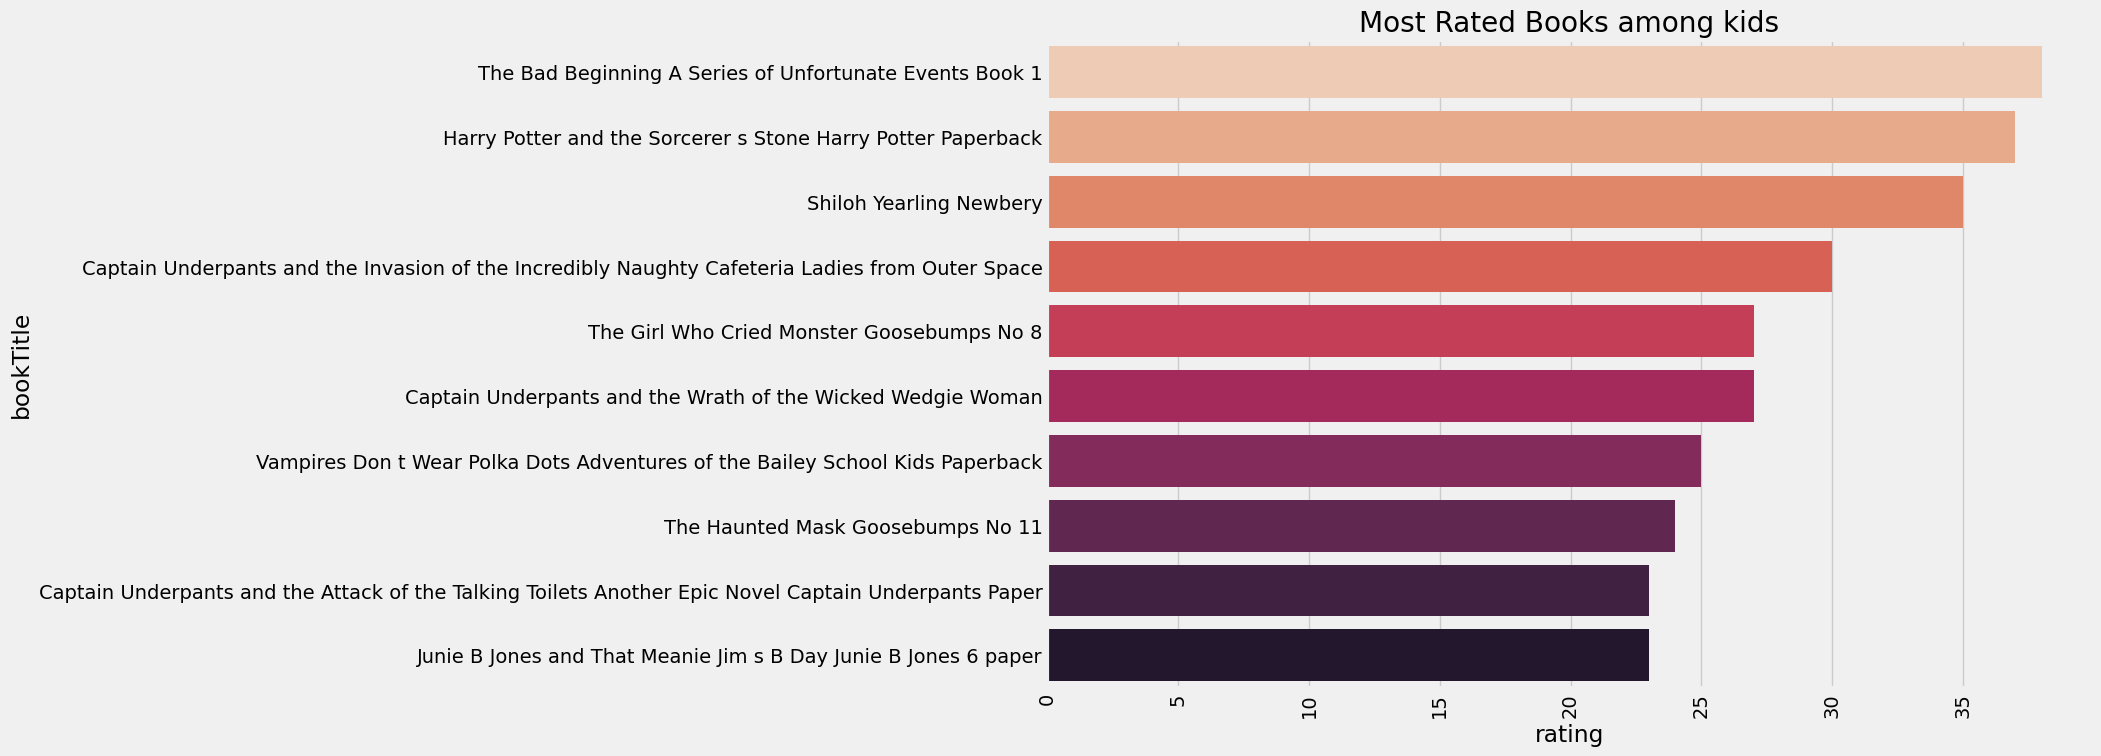

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_kid, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books among kids")

1. **Harry Potter and Sorcerer's stone is the most popular book among kids**
2. **This list differs completely from the popular books from whole collection**

In [ ]:
ratings_count_adult = pd.DataFrame(Final_dataset1_adult.groupby(['ISBN'])['rating'].sum())
top_10_adult = ratings_count_adult.sort_values('rating',ascending=False).head(10)
top_10_adult = top_10_adult.merge(book,left_index = True,right_on = 'ISBN')
top_10_adult

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,4472,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3034,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2555,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2088,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2023,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
1105,1977,60928336,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,1880,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,1757,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,1672,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
26,1670,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books among adults')

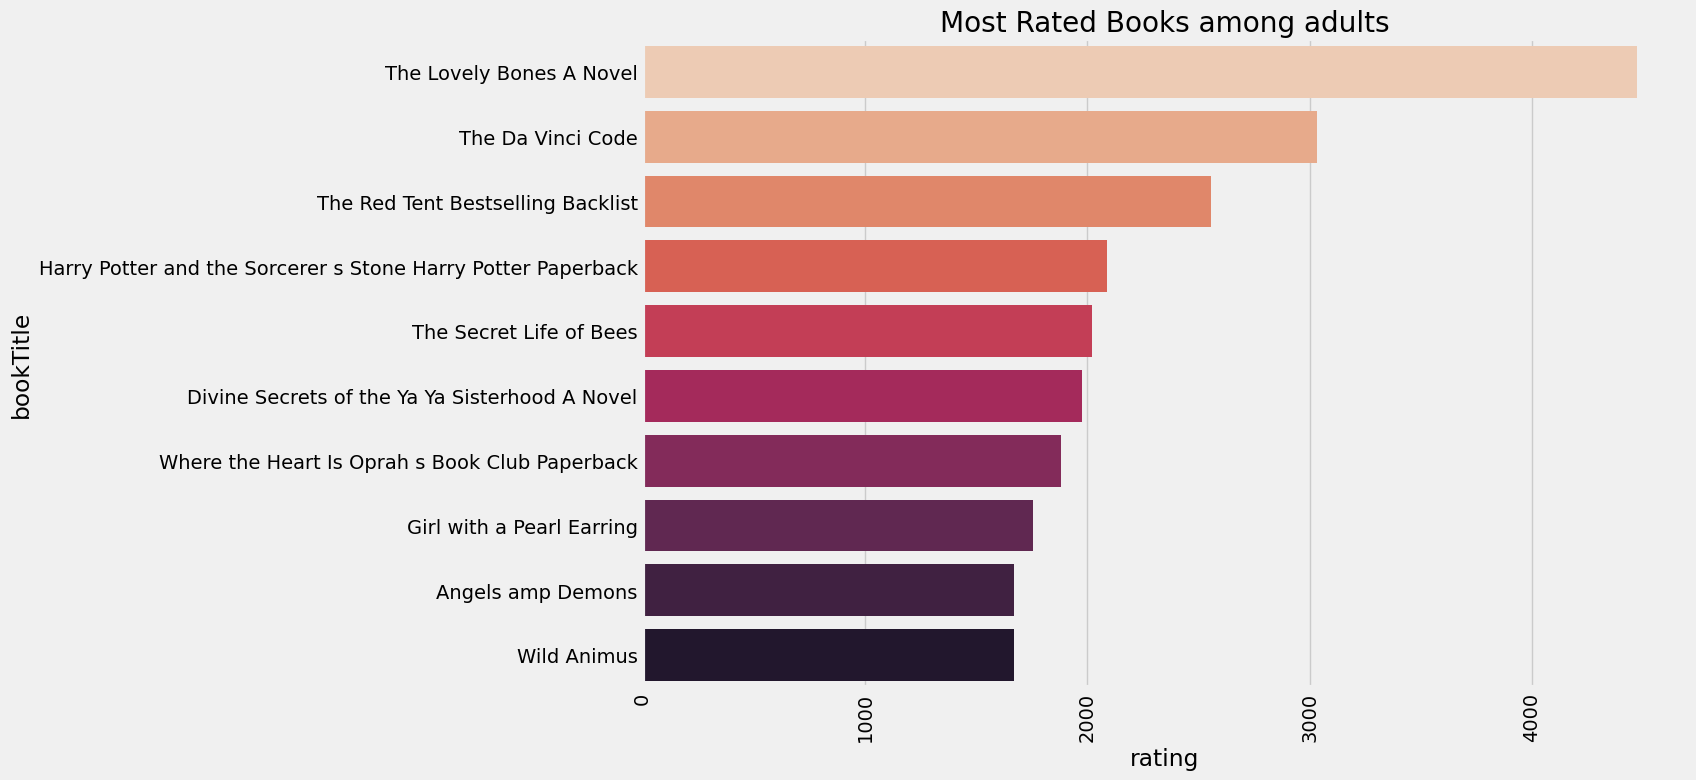

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_adult, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books among adults")

1. **The Lovely Bones: A Novel is popular among adults**
2. **The 9 out of 10 popular books for adults is same as popular book for the whole collection. Because, Most number of users are adults in the whole dataset**

In [ ]:
ratings_count_old = pd.DataFrame(Final_dataset1_old.groupby(['ISBN'])['rating'].sum())
top_10_old = ratings_count_old.sort_values('rating',ascending=False).head(10)
top_10_old = top_10_old.merge(book,left_index = True,right_on = 'ISBN')
top_10_old

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
748,717,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
408,496,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
26,387,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1406,341,1400034779,The No 1 Ladies Detective Agency Today Show Book Club 8,Alexander McCall Smith,2003,Anchor,http://images.amazon.com/images/P/1400034779.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1400034779.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1400034779.01.LZZZZZZZ.jpg
107,326,786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.LZZZZZZZ.jpg
118,325,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
356,322,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
522,292,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
305,268,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
5662,241,440241073,The Summons,John Grisham,2002,Dell Publishing Company,http://images.amazon.com/images/P/0440241073.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books among old people')

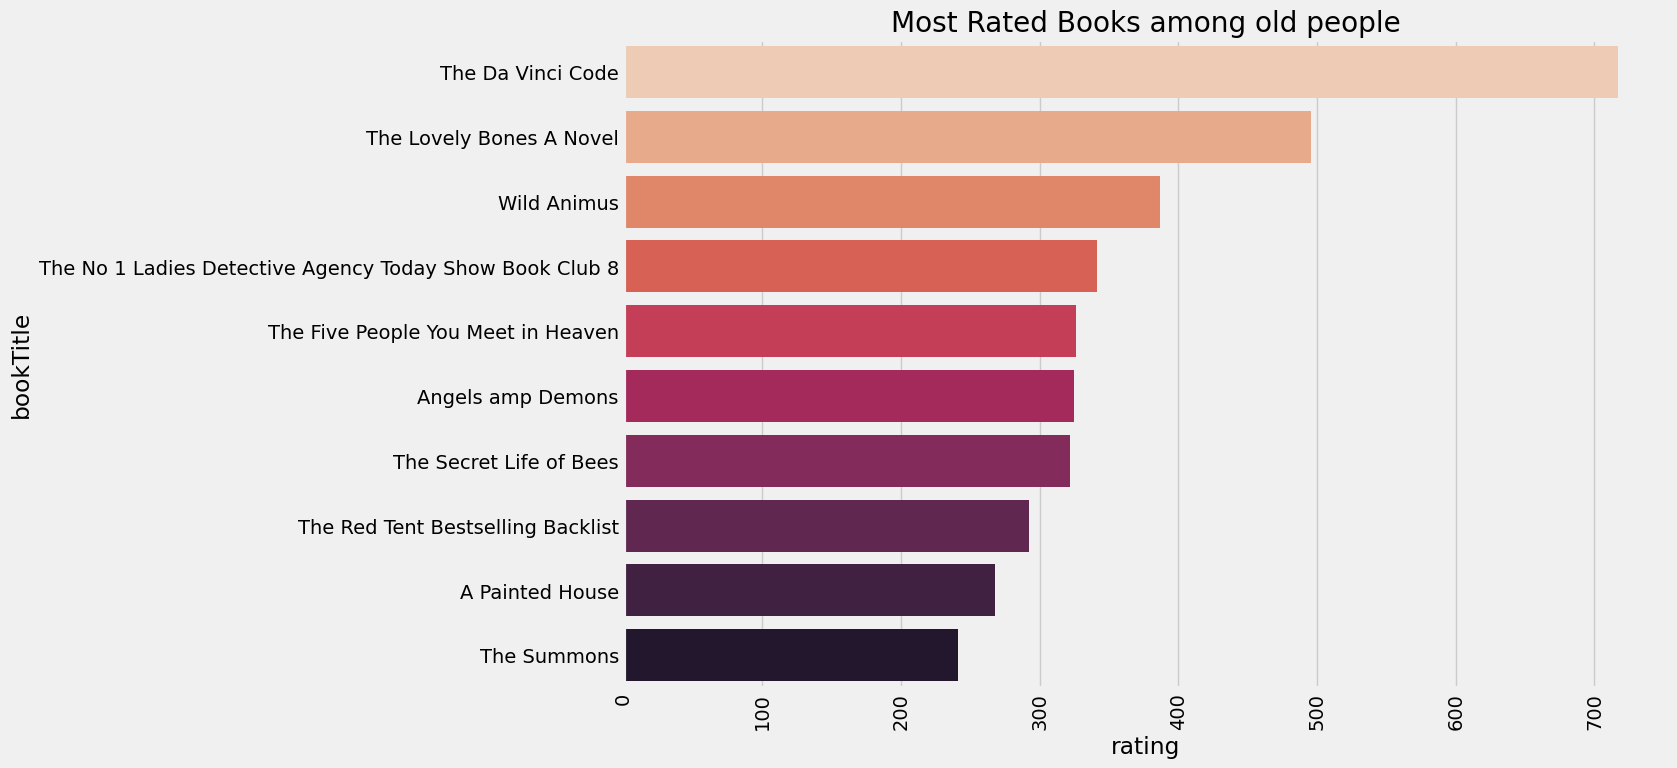

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_old, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books among old people")

1. **"The Da Vinci Code" is most popular book among old people.**
2. **6 out of 10 books are same for old people and the whole collection and 5 books match for adults and old people**

#### So, the Popular books differ according to age. So we have to build different reccomendation engines for different age groups

### Q3. Does popularity differ for different centuries of publication?

In [ ]:
ratings_count_19 = pd.DataFrame(Final_dataset1_19.groupby(['ISBN'])['rating'].sum())
top_10_19 = ratings_count_19.sort_values('rating',ascending=False).head(10)
top_10_19 = top_10_19.merge(book,left_index = True,right_on = 'ISBN')
top_10_19

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
522,2890,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2546,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
1105,2292,60928336,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2145,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
4824,1815,316601950,The Pilot s Wife A Novel,Anita Shreve,1999,Back Bay Books,http://images.amazon.com/images/P/0316601950.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.LZZZZZZZ.jpg
1922,1810,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.LZZZZZZZ.jpg
37,1740,446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446310786.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446310786.01.LZZZZZZZ.jpg
90,1704,316769487,The Catcher in the Rye,J.D. Salinger,1991,"Little, Brown",http://images.amazon.com/images/P/0316769487.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316769487.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316769487.01.LZZZZZZZ.jpg
1373,1656,60930535,The Poisonwood Bible A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060930535.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060930535.01.LZZZZZZZ.jpg
2526,1612,345337662,Interview with the Vampire,Anne Rice,1993,Ballantine Books,http://images.amazon.com/images/P/0345337662.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books which published in 19th century')

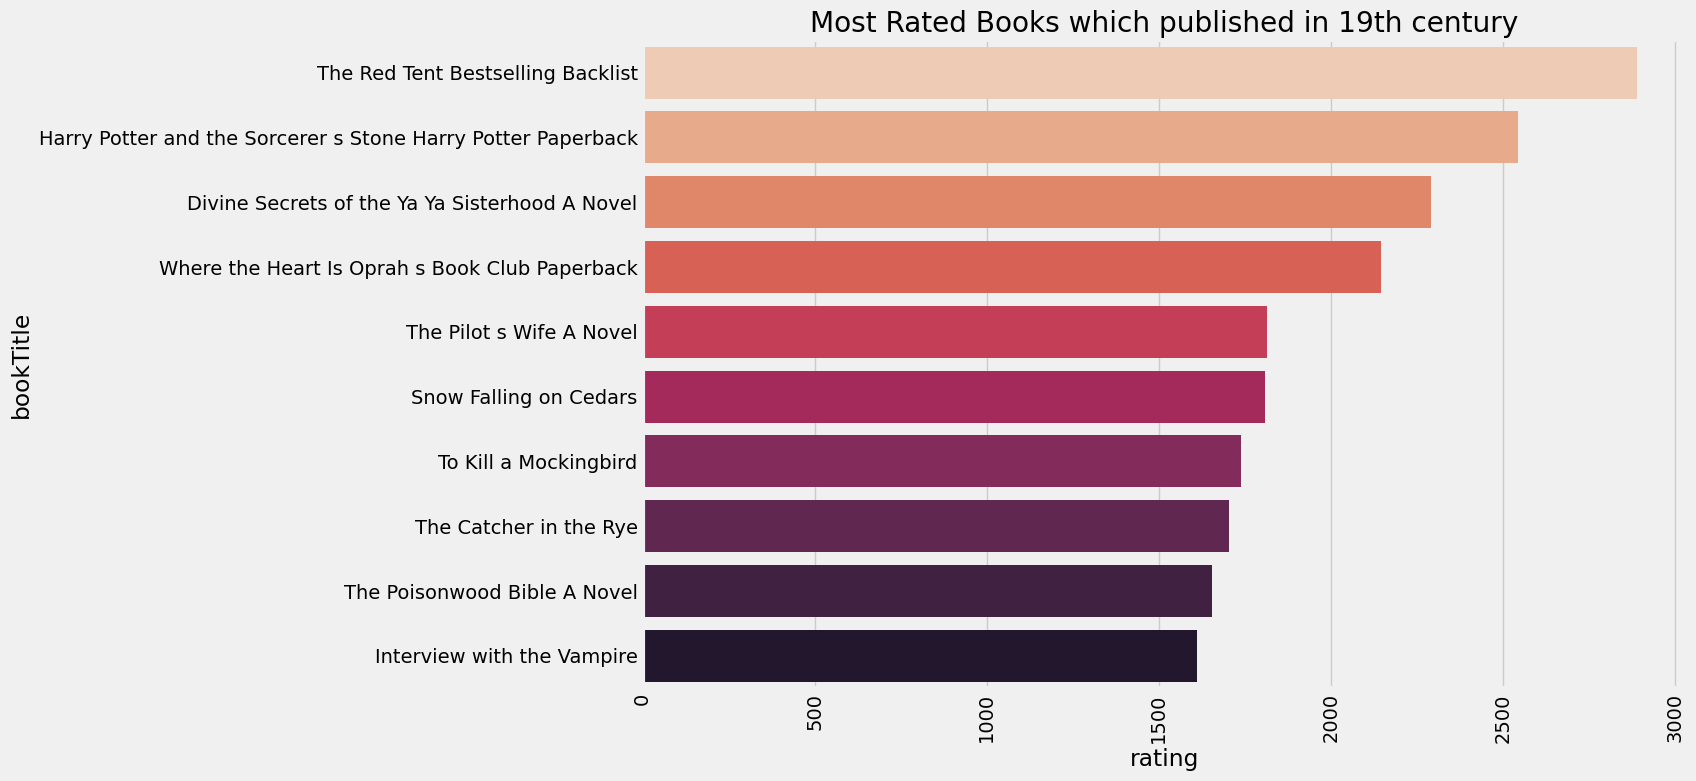

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_19, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books which published in 19th century")

**Among the books published in 19th century, "The Red Tent" is the most popular book**

In [ ]:
ratings_count_20 = pd.DataFrame(Final_dataset1_20.groupby(['ISBN'])['rating'].sum())
top_10_20 = ratings_count_20.sort_values('rating',ascending=False).head(10)
top_10_20 = top_10_20.merge(book,left_index = True,right_on = 'ISBN')
top_10_20

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5188,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3814,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
356,2404,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2337,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
118,2043,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
231,2040,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
305,1884,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
1496,1794,743418174,Good in Bed,Jennifer Weiner,2002,Washington Square Press,http://images.amazon.com/images/P/0743418174.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.LZZZZZZZ.jpg
107,1764,786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.LZZZZZZZ.jpg
5506,1704,043935806X,Harry Potter and the Order of the Phoenix Book 5,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books which published in 20h century')

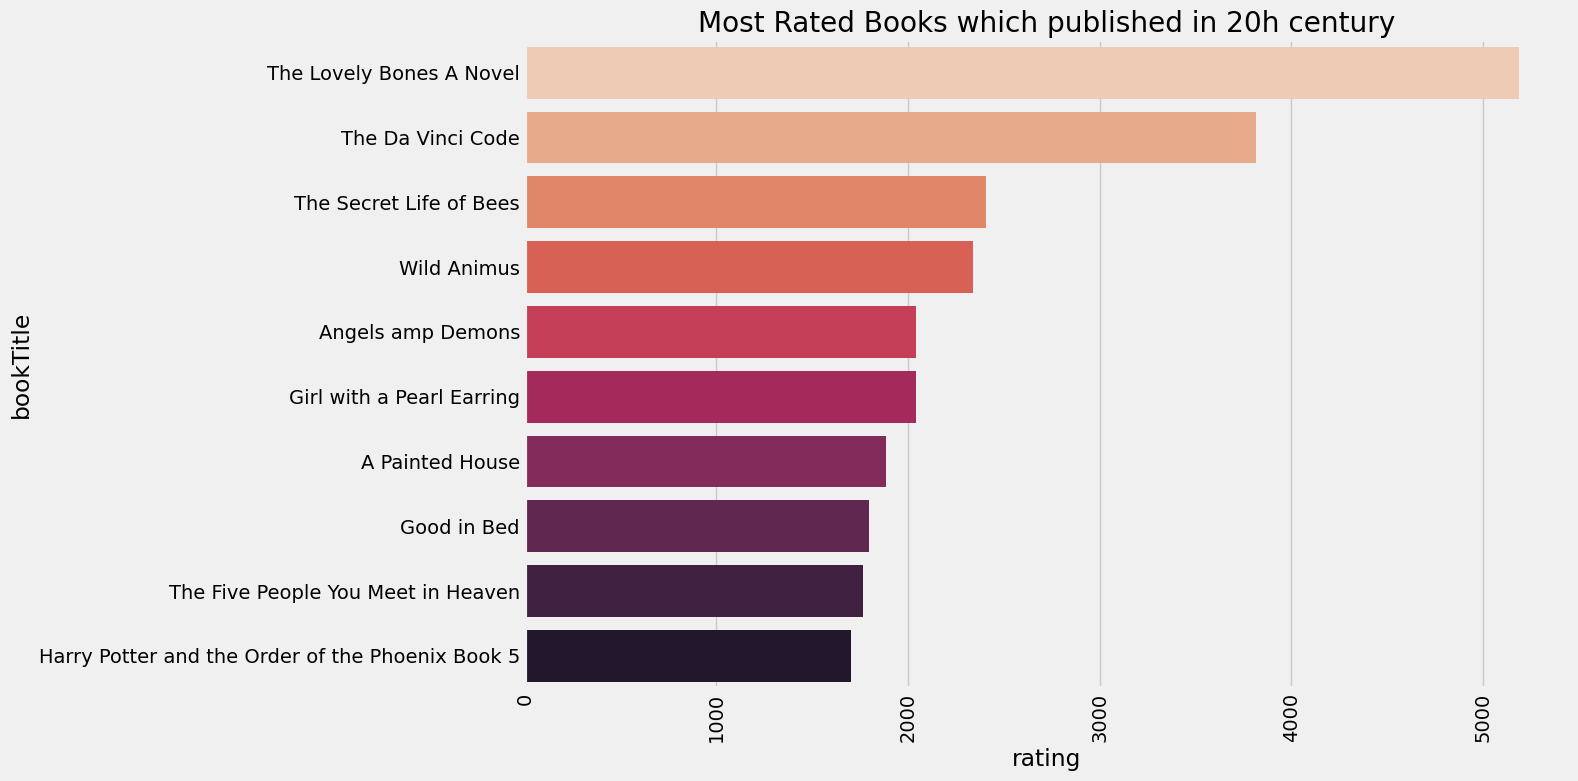

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_20, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books which published in 20h century")

1. **The Lovely Bones : A Novel is the most popular book among the books published in the 20th century.**
2. **The 6 books out of 10 books in the popular books of whole collection are published in 20th century**

#### So, the Popular books can be found according to different centuries they have published.

#### From above graphs, we can say that "The Lovely Bones : The Novel" is most popular book among most of the age groups and countries

# Model Building

## Popularity based recommendation

### 1.Top 10 books in whole collection

In [ ]:
def popularity_based(dataframe):
    data = pd.DataFrame(dataframe.groupby(['ISBN'])['rating'].sum()).sort_values('rating',ascending=False).head(10)
    result = data.merge(book,left_index = True,right_on = 'ISBN')
    return result

In [ ]:
print("Top 10 popular books in the whole collection are:")
popularity_based(Final_dataset1)

Top 10 popular books in the whole collection are:


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5188,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3814,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2890,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2546,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2404,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2337,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1105,2292,60928336,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2145,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
118,2043,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
231,2040,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg


### 2. Top 10 books in a particular country

In [ ]:
def Country_filter(dataframe,Country):
    Country = Country.lower()

    if Country in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == Country]
    else:
        return dataframe

In [ ]:
Country = input("Enter your country name: ")
data = Country_filter(Final_dataset1,Country)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter your country name: India


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26,22,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
167,17,486284735,Pride and Prejudice Dover Thrift Editions,Jane Austen,1995,Dover Publications,http://images.amazon.com/images/P/0486284735.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0486284735.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0486284735.01.LZZZZZZZ.jpg
9682,16,8171670407,Inscrutable Americans,Mathur Anurag,1996,South Asia Books,http://images.amazon.com/images/P/8171670407.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/8171670407.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/8171670407.01.LZZZZZZZ.jpg
169,12,671047612,Skin And Bones,Franklin W. Dixon,2000,Aladdin,http://images.amazon.com/images/P/0671047612.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671047612.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671047612.01.LZZZZZZZ.jpg
124331,10,968217532,Bob the Angry Flower The Ultimate Book of Perfect Energy,Stephen Notley,2003,Leftover Books,http://images.amazon.com/images/P/0968217532.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0968217532.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0968217532.01.LZZZZZZZ.jpg
142569,10,1410764389,World in Equilibrium An Alternative Approach to the Theory of Emergence of Species,Pankaj Vallabh,2003,1stBooks Library,http://images.amazon.com/images/P/1410764389.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1410764389.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1410764389.01.LZZZZZZZ.jpg
75075,10,765300974,The World of Null A,A. E. Van Vogt,2002,Orb Books,http://images.amazon.com/images/P/0765300974.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0765300974.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0765300974.01.LZZZZZZZ.jpg
263914,10,131774298,Expert C Programming,Peter van der Linden,1994,Prentice Hall PTR,http://images.amazon.com/images/P/0131774298.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0131774298.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0131774298.01.LZZZZZZZ.jpg
124337,10,312852363,Slan,A. E. Van Vogt,1998,Orb Books,http://images.amazon.com/images/P/0312852363.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312852363.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312852363.01.LZZZZZZZ.jpg
63259,10,262193388,The Art of Prolog Second Edition Advanced Programming Techniques Logic Programming,Leon Sterling,1994,The MIT Press,http://images.amazon.com/images/P/0262193388.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0262193388.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0262193388.01.LZZZZZZZ.jpg


### 3.Top 10 books for particular age group

In [ ]:
def age_filter(dataframe,Age):
    if Age in range(0,13):
        return dataframe[dataframe['Age_group'] == 'kid']
    elif Age in range(13,20):
        return dataframe[dataframe['Age_group'] == 'Teenager']
    elif Age in range(20,51):
        return dataframe[dataframe['Age_group'] == 'Adult']
    elif Age in range(51,101):
        return dataframe[dataframe['Age_group'] == 'old']
    else:
        return dataframe

In [ ]:
Age = int(input("Enter your age:"))
data = age_filter(Final_dataset1,Age)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter your age:25


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,4472,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3034,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2555,312195516,The Red Tent Bestselling Backlist,Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2088,059035342X,Harry Potter and the Sorcerer s Stone Harry Potter Paperback,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2023,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
1105,1977,60928336,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,1880,446672211,Where the Heart Is Oprah s Book Club Paperback,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,1757,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,1672,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
26,1670,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg


### 4. Top 10 books of a particular publication century

In [ ]:
def century_filter(dataframe,Publication_century):

    if Publication_century in list(dataframe['Publication_century'].unique()):
        return dataframe[dataframe['Publication_century'] == Publication_century]
    else:
        print("As we don't have the books from the publication century you asked,we reccommend you most popular books in our collection")
        return dataframe

In [ ]:
Publication_century = int(input("Enter the publication century you want books from: "))
data = century_filter(Final_dataset1,Publication_century)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter the publication century you want books from: 20


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5188,316666343,The Lovely Bones A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3814,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
356,2404,142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2337,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
118,2043,671027360,Angels amp Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
231,2040,452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
305,1884,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
1496,1794,743418174,Good in Bed,Jennifer Weiner,2002,Washington Square Press,http://images.amazon.com/images/P/0743418174.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.LZZZZZZZ.jpg
107,1764,786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.LZZZZZZZ.jpg
5506,1704,043935806X,Harry Potter and the Order of the Phoenix Book 5,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.LZZZZZZZ.jpg


### 5. Top 10 books for a person of a particular age group and a perticular Country

In [ ]:
def individual_filter(dataframe,Country,Age):
    Country = Country.lower()

    if (Country in list(dataframe['Country'].unique()) and Age in range(0,13)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'kid')]
    elif (Country in list(dataframe['Country'].unique()) and Age in range(13,20)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'Teenager')]
    elif (Country in list(dataframe['Country'].unique()) and Age in range(20,51)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'Adult')]
    elif (Country in list(dataframe['Country'].unique()) and Age in range(51,101)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'old')]
    else:
        print("These are the popular books in our whole collection")
        return dataframe

In [ ]:
#For userId 165618

In [ ]:
userId = int(input("Enter your userId:"))
Country = Final_dataset1.loc[Final_dataset1['userId']==userId,'Country'].iloc[0]
Age = Final_dataset1.loc[Final_dataset1['userId']==userId,'Age'].iloc[0]

data = individual_filter(Final_dataset1,Country,Age)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter your userId:165618


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2882,196,3257229534,Der Vorleser,Bernhard Schlink,1999,Diogenes Verlag AG,http://images.amazon.com/images/P/3257229534.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3257229534.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3257229534.01.LZZZZZZZ.jpg
11174,195,3404148665,Illuminati,Dan Brown,2003,LÃƒ?Ã‚Â¼bbe,http://images.amazon.com/images/P/3404148665.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3404148665.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3404148665.01.LZZZZZZZ.jpg
3363,186,3442541751,Russendisko,Wladimir Kaminer,2002,Goldmann,http://images.amazon.com/images/P/3442541751.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3442541751.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3442541751.01.LZZZZZZZ.jpg
4622,172,3492045170,Stupid White Men Eine Abrechnung mit dem Amerika unter George W Bush,Michael Moore,2003,Piper,http://images.amazon.com/images/P/3492045170.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3492045170.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3492045170.01.LZZZZZZZ.jpg
8838,159,3423202327,MÃƒ Ã Â rder ohne Gesicht,Henning Mankell,1999,Dtv,http://images.amazon.com/images/P/3423202327.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3423202327.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3423202327.01.LZZZZZZZ.jpg
1993,140,3257228007,Das Parfum Die Geschichte Eines Morders,Patrick Suskind,1994,Distribooks Inc,http://images.amazon.com/images/P/3257228007.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3257228007.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3257228007.01.LZZZZZZZ.jpg
36276,127,3453007867,Friedhof der Kuscheltiere Roman,Stephen King,1988,Heyne,http://images.amazon.com/images/P/3453007867.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3453007867.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3453007867.01.LZZZZZZZ.jpg
5053,126,325722575X,Der Hahn ist tot Roman,Ingrid Noll,1993,Diogenes Verlag,http://images.amazon.com/images/P/325722575X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/325722575X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/325722575X.01.LZZZZZZZ.jpg
52831,123,3442092981,Felidae Roman,Akif Pirincci,1989,Goldmann,http://images.amazon.com/images/P/3442092981.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3442092981.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3442092981.01.LZZZZZZZ.jpg
3038,122,3423204206,Die falsche FÃƒ Ã Â hrte,Henning Mankell,2001,Dtv,http://images.amazon.com/images/P/3423204206.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/3423204206.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/3423204206.01.LZZZZZZZ.jpg


## Collaborative filtering

In [ ]:
dataset = Final_dataset.copy()
dataset.shape

(941103, 14)

In [ ]:
new_df = dataset[['userId','ISBN','bookTitle','rating']]
new_df.head()

,userId,ISBN,bookTitle,rating
0,2,195153448,Classical Mythology,0
1,8,2005018,Clara Callan,5
2,11400,2005018,Clara Callan,0
3,11676,2005018,Clara Callan,8
4,41385,2005018,Clara Callan,0


In [ ]:
len(new_df.userId.unique())

83643

In [ ]:
len(new_df.bookTitle.unique())

228330

In [ ]:
new_df=new_df[new_df['userId'].map(new_df['userId'].value_counts()) > 200]  # Drop users who vote less than 200 times.

In [ ]:
new_df['Total_No_Of_Users_Rated']=new_df.groupby('ISBN')['rating'].transform('count')

In [ ]:
new_df=new_df[new_df['Total_No_Of_Users_Rated']>50]
new_df

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
94,2977,440234743,The Testament,0,106
96,3363,440234743,The Testament,0,106
99,7346,440234743,The Testament,9,106
105,11676,440234743,The Testament,9,106
108,13552,440234743,The Testament,8,106
...,...,...,...,...,...
453124,242083,312971125,Crazy for You,6,56
453125,242106,312971125,Crazy for You,0,56
453126,242299,312971125,Crazy for You,0,56
453128,244688,312971125,Crazy for You,0,56


In [ ]:
users_pivot=new_df.pivot_table(index=["userId"],columns=["bookTitle"],values="rating")

In [ ]:
users_pivot.fillna(0,inplace = True)
users_pivot

bookTitle,1st to Die A Novel,2nd Chance,4 Blondes,A Bend in the Road,A Case of Need,A Child Called It One Child s Courage to Survive,A Heartbreaking Work of Staggering Genius,A Is for Alibi Kinsey Millhone Mysteries Paperback,A Lesson Before Dying Vintage Contemporaries Paperback,A Map of the World,...,While I Was Gone,While My Pretty One Sleeps,Whirlwind Tyler Book 1,White Oleander A Novel,White Oleander A Novel Oprah s Book Club,Wicked The Life and Times of the Wicked Witch of the West,Wild Animus,Without Remorse,Year of Wonders,You Belong To Me
userId,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
similarity = cosine_similarity(users_pivot)
similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
similarity.shape

(733, 733)

In [ ]:
def user_based(new_df,user_id):
        index=np.where(users_pivot.index==user_id)[0][0]
        similar_users=list(enumerate(similarity[index]))
        similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:10]

        user_rec=[]

        for i in similar_users:
                data=new_df[new_df["userId"]==users_pivot.index[i[0]]]
                user_rec.extend(list(data.drop_duplicates("userId")["userId"].values))
        return user_rec

In [ ]:
def common(new_df,user,user_id):
    x=new_df[new_df["userId"]==user_id]
    y = []
    user=list(user)
    for i in user:
        y=new_df[new_df['userId'].isin(user)]
        books=y.loc[~(y["bookTitle"].isin(x["bookTitle"])),:]
        books=books.sort_values(["rating"],ascending=False)
        books = books.drop_duplicates(subset=['bookTitle'])
        books = books[0:10]

    return books

## Examples:

In [ ]:
#For userId 1
user_id=int(input("Enter the userid: "))

if user_id not in new_df['userId'].values:
    if user_id not in Final_dataset1['userId'].values:
        data = popularity_based(Final_dataset1)
        print(data[['bookTitle']])

    else:
        Country = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Country'].iloc[0]
        Age = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Age'].iloc[0]
        data = individual_filter(Final_dataset1,Country,Age)
        if isinstance(data,pd.DataFrame):
            data = popularity_based(data)
            print(data[['bookTitle']])

else:
    user_based_rec = user_based(new_df,user_id)
    books_for_user = common(new_df,user_based_rec,user_id)
    print("=====Recommended books=====".title())
    rec_books =  books_for_user[['bookTitle','rating']]
    print(rec_books)

Enter the userid: 1
                                                         bookTitle
408                                       The Lovely Bones A Novel
748                                              The Da Vinci Code
522                              The Red Tent Bestselling Backlist
2143  Harry Potter and the Sorcerer s Stone Harry Potter Paperback
356                                        The Secret Life of Bees
26                                                     Wild Animus
1105                Divine Secrets of the Ya Ya Sisterhood A Novel
706                 Where the Heart Is Oprah s Book Club Paperback
118                                              Angels amp Demons
231                                      Girl with a Pearl Earring


In [ ]:
#For userId 153662
user_id=int(input("Enter the userid: "))

if user_id not in new_df['userId'].values:
    if user_id not in Final_dataset1['userId'].values:
        data = popularity_based(Final_dataset1)
        print(data[['bookTitle']])

    else:
        Country = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Country'].iloc[0]
        Age = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Age'].iloc[0]
        data = individual_filter(Final_dataset1,Country,Age)
        if isinstance(data,pd.DataFrame):
            data = popularity_based(data)
            print(data[['bookTitle']])
else:
    user_based_rec = user_based(new_df,user_id)
    books_for_user = common(new_df,user_based_rec,user_id)
    print("=====Recommended books=====".title())
    rec_books = books_for_user[['bookTitle','rating']]
    print(rec_books)

Enter the userid: 153662
=====Recommended Books=====
                                                   bookTitle  rating
103619                                        The Lost World      10
26373                                 White Oleander A Novel      10
103886   Cruel amp Unusual Kay Scarpetta Mysteries Paperback      10
283942   C Is for Corpse Kinsey Millhone Mysteries Paperback      10
122994                                            Sick Puppy      10
97196   What to Expect When You re Expecting Revised Edition      10
12762                                         Lucky A Memoir      10
249414                       Seven Up A Stephanie Plum Novel      10
120763                                          Dreamcatcher      10
194584                                              The Reef      10


In [ ]:
#For userId 46398
user_id=int(input("Enter the userid: "))

if user_id not in new_df['userId'].values:
    if user_id not in Final_dataset1['userId'].values:
        data = popularity_based(Final_dataset1)
        print(data[['bookTitle']])

    else:
        Country = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Country'].iloc[0]
        Age = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Age'].iloc[0]
        data = individual_filter(Final_dataset1,Country,Age)
        if isinstance(data,pd.DataFrame):
            data = popularity_based(data)
            print(data[['bookTitle']])
else:
    user_based_rec = user_based(new_df,user_id)
    books_for_user = common(new_df,user_based_rec,user_id)
    print("=====Recommended books=====".title())
    rec_books =  books_for_user[['bookTitle','rating']]
    print(rec_books)

Enter the userid: 46398
=====Recommended Books=====
                                                      bookTitle  rating
103886      Cruel amp Unusual Kay Scarpetta Mysteries Paperback      10
51329   Fast Food Nation The Dark Side of the All American Meal      10
29250            Harry Potter and the Chamber of Secrets Book 2      10
89554                      At Home in Mitford The Mitford Years      10
196686                                             The Hot Zone      10
198556            Heaven and Earth Three Sisters Island Trilogy      10
286783                          Jewels of the Sun Irish Trilogy      10
199098                 What Looks Like Crazy On An Ordinary Day      10
84141    Confessions of a Shopaholic Summer Display Opportunity      10
79518                                        A Bend in the Road      10


In [ ]:
#For userId 3363
user_id=int(input("Enter the userid: "))

if user_id not in new_df['userId'].values:
    if user_id not in Final_dataset1['userId'].values:
        data = popularity_based(Final_dataset1)
        print(data[['bookTitle']])

    else:
        Country = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Country'].iloc[0]
        Age = Final_dataset1.loc[Final_dataset1['userId']==user_id,'Age'].iloc[0]
        data = individual_filter(Final_dataset1,Country,Age)
        if isinstance(data,pd.DataFrame):
            data = popularity_based(data)
            print(data[['bookTitle']])

else:
    user_based_rec = user_based(new_df,user_id)
    books_for_user = common(new_df,user_based_rec,user_id)
    print("=====Recommended books=====".title())
    rec_books =  books_for_user[['bookTitle','rating']]
    print(rec_books)

Enter the userid: 3363
=====Recommended Books=====
                                                       bookTitle  rating
24890                                      Bridget Jones s Diary      10
89561                       At Home in Mitford The Mitford Years      10
29515             Harry Potter and the Chamber of Secrets Book 2      10
7506    Midnight in the Garden of Good and Evil A Savannah Story       9
49145   Lamb The Gospel According to Biff Christ s Childhood Pal       9
201594                     The Idiot Girls Action Adventure Club       9
253829            All the Pretty Horses The Border Trilogy Vol 1       9
25508                                    The Secret Life of Bees       8
100439                                           Year of Wonders       8
46523                                                 Life of Pi       8


## Evaluation

* **In the evaluation part, we have taken 5 random users, we haven't removed the books which are read by the given user Id and sorted the books in the descending order of their rating and recommended 10 most rated books.**
* **And we have checked the rating of each book by the given user Id.**
* **We found that all the 10 books by the random users fall in the range of >5 rating by the given user.**
* **So we can say that our engine is working efficiently**

In [ ]:
def common_ev(new_df,user,user_id):
    x=new_df[new_df["userId"]==user_id]
    y = []
    user=list(user)
    for i in user:
        y=new_df[new_df['userId'].isin(user)]
        #books=y.loc[~(y["bookTitle"].isin(x["bookTitle"])),:]
        books=y.sort_values(["rating"],ascending=False)
        books = books.drop_duplicates(subset=['bookTitle'])
        books = books[0:10]

    return books

In [ ]:
user_id=random.choice(new_df["userId"].values)
user_id

69232

In [ ]:
#for userId 11676
user_id=int(input("Enter the userid: "))
user_based_rec = user_based(new_df,user_id)
books_for_user = common_ev(new_df,user_based_rec,user_id)
print("=====Recommended books=====".title())
rec_books =  books_for_user[['bookTitle','rating']]
print(rec_books)

Enter the userid: 11676
=====Recommended Books=====
                                                                           bookTitle  \
114544                  Harry Potter and the Sorcerer s Stone Harry Potter Paperback   
151740  Tribulation Force The Continuing Drama of Those Left Behind Left Behind No 2   
103917                           Cruel amp Unusual Kay Scarpetta Mysteries Paperback   
103619                                                                The Lost World   
100940                                                                Cause of Death   
100411                                                               Year of Wonders   
99522                                                                  Into the Wild   
95962                                                               Call of the Wild   
93757                        The Fellowship of the Ring The Lord of the Rings Part 1   
89554                                           At Home in Mitford T

In [ ]:
new_df[(new_df["userId"]==11676)&(new_df["bookTitle"]=="At Home in Mitford The Mitford Years")]

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
89554,11676,014025448X,At Home in Mitford The Mitford Years,10,71


So in the above recommendation,
* Number of books rated >5 = 7
* Number of books rated <5 = 0
* Number of books not read = 3

In [ ]:
#for userId 95359
user_id=int(input("Enter the userid: "))
user_based_rec = user_based(new_df,user_id)
books_for_user = common_ev(new_df,user_based_rec,user_id)
print("=====Recommended books=====".title())
rec_books =  books_for_user[['bookTitle','rating']]
print(rec_books)

Enter the userid: 95359
=====Recommended Books=====
                                                      bookTitle  rating
11031                                         Atonement A Novel      10
12762                                            Lucky A Memoir      10
14293                                  The Lovely Bones A Novel      10
25219                                                  Chocolat      10
86223                                   A Prayer for Owen Meany      10
237776                     The Sweet Potato Queens Book of Love      10
189108                                      The Prince of Tides      10
87474   The No 1 Ladies Detective Agency Today Show Book Club 8      10
13205                                  The Pilot s Wife A Novel      10
26096                                         The Hours A Novel      10


In [ ]:
new_df[(new_df["userId"]==95359)&(new_df["bookTitle"]=="The Hours A Novel")]

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
26096,95359,312305060,The Hours A Novel,10,81


So in the above recommendation,
* Number of books rated >5 = 7
* Number of books rated <5 = 0
* Number of books not read = 3

In [ ]:
#For userId 98391
user_id=int(input("Enter the userid: "))
user_based_rec = user_based(new_df,user_id)
books_for_user = common_ev(new_df,user_based_rec,user_id)
print("=====Recommended books=====".title())
rec_books =  books_for_user[['bookTitle','rating']]
print(rec_books)

Enter the userid: 98391
=====Recommended Books=====
                                                   bookTitle  rating
60165                                      The Da Vinci Code      10
128045                    Key of Light Key Trilogy Paperback      10
97196   What to Expect When You re Expecting Revised Edition      10
128151                Key of Knowledge Key Trilogy Paperback      10
223040                                             The Villa      10
21482                                          Carolina Moon      10
41583                                               The Firm      10
286838                       Jewels of the Sun Irish Trilogy      10
103989   Cruel amp Unusual Kay Scarpetta Mysteries Paperback      10
39263                         Heart of the Sea Irish Trilogy      10


In [ ]:
new_df[(new_df["userId"]==98391)&(new_df["bookTitle"]=="Heart of the Sea Irish Trilogy")]

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated


So in the above recommendation,
* Number of books rated >5 = 4
* Number of books rated <5 = 0
* Number of books not read = 6

In [ ]:
#For userId 13273
user_id=int(input("Enter the userid: "))
user_based_rec = user_based(new_df,user_id)
books_for_user = common_ev(new_df,user_based_rec,user_id)
print("=====Recommended books=====".title())
rec_books =  books_for_user[['bookTitle','rating']]
print(rec_books)

Enter the userid: 13273
=====Recommended Books=====
                                             bookTitle  rating
145094                                Midwives A Novel      10
6746                                        Seabiscuit      10
13105                         The Pilot s Wife A Novel      10
66288                                   A Time to Kill      10
9513                                 Angels amp Demons      10
60110                                The Da Vinci Code      10
89561             At Home in Mitford The Mitford Years      10
57422   Where the Heart Is Oprah s Book Club Paperback      10
27910                                       Neverwhere       9
14544                         The Lovely Bones A Novel       9


In [ ]:
new_df[(new_df["userId"]==13273)&(new_df["bookTitle"]=="The Lovely Bones A Novel")]

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
13699,13273,316666343,The Lovely Bones A Novel,8,233


So in the above recommendation,
* Number of books rated >5 = 9
* Number of books rated <5 = 0
* Number of books not read = 1

In [ ]:
#For userId 125774
user_id=int(input("Enter the userid: "))
user_based_rec = user_based(new_df,user_id)
books_for_user = common_ev(new_df,user_based_rec,user_id)
print("=====Recommended books=====".title())
rec_books =  books_for_user[['bookTitle','rating']]
print(rec_books)

Enter the userid: 125774
=====Recommended Books=====
                                                         bookTitle  rating
39255                               Heart of the Sea Irish Trilogy      10
152884  The Hobbit The Enchanting Prelude to The Lord of the Rings      10
128151                      Key of Knowledge Key Trilogy Paperback      10
346767                       Inner Harbor Quinn Brothers Paperback      10
33539                   Face the Fire Three Sisters Island Trilogy      10
49471                                      Angela s Ashes A Memoir      10
21482                                                Carolina Moon      10
266868                                            Schindler s List      10
22588          Chicken Soup for the Soul Chicken Soup for the Soul      10
22983    Wicked The Life and Times of the Wicked Witch of the West      10


In [ ]:
new_df[(new_df["userId"]==125774)&(new_df["bookTitle"]=="Wicked The Life and Times of the Wicked Witch of the West")]

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated


So in the above recommendation,
* Number of books rated >5 = 1
* Number of books rated <=5 = 0
* Number of books not read = 9

Accuracy =56%

## Converting into pickle file

In [ ]:
userId_list = list(Final_dataset['userId'].unique())
userId_list

[2,
 8,
 11400,
 11676,
 41385,
 67544,
 85526,
 96054,
 116866,
 123629,
 177458,
 200273,
 210926,
 219008,
 2954,
 152827,
 35704,
 83160,
 110912,
 137688,
 157969,
 169187,
 192665,
 197659,
 208059,
 209163,
 29526,
 36836,
 46398,
 49300,
 49635,
 67958,
 113270,
 113519,
 115097,
 136509,
 148712,
 153461,
 178269,
 180297,
 188589,
 194722,
 198013,
 200674,
 207148,
 211919,
 212449,
 213191,
 230522,
 236322,
 238557,
 242247,
 245827,
 248583,
 52614,
 56193,
 225910,
 24539,
 98499,
 166596,
 189238,
 223066,
 92861,
 3363,
 61501,
 148514,
 174304,
 177090,
 176875,
 213915,
 35826,
 226745,
 9,
 243,
 388,
 2977,
 3329,
 5760,
 6795,
 7346,
 7352,
 9419,
 9747,
 9856,
 11224,
 12685,
 12923,
 13552,
 13582,
 14521,
 16666,
 16795,
 17761,
 19445,
 20435,
 20462,
 20783,
 20801,
 20916,
 21264,
 23511,
 23768,
 26240,
 26544,
 26593,
 27684,
 28123,
 28619,
 29654,
 30487,
 30533,
 31299,
 31315,
 31556,
 31560,
 31694,
 32516,
 35857,
 35859,
 36606,
 37874,
 38718,
 389

In [ ]:
import pickle

In [ ]:
pickle.dump(userId_list,open('userId_list.pkl','wb'))

In [ ]:
pickle.dump(users_pivot, open('users_pivot.pkl','wb'))

In [ ]:
pickle.dump(Final_dataset1,open('Final_dataset1.pkl','wb'))

In [ ]:
pickle.dump(new_df,open('new_df.pkl','wb'))

In [ ]:
pickle.dump(similarity,open('similarity.pkl','wb'))

In [ ]:
A = pickle.load(open('new_df.pkl','rb'))

In [ ]:
pickle.dump(book,open('book.pkl','wb'))